# TREBL Quick Start Example

This notebook demonstrates a quick start workflow for TREBL analysis with:
- **No error correction** (faster processing)
- **Simple UMI deduplication only** (for Step 1 - TREBL experiment)

This is ideal for initial data exploration or when processing time is a priority.

**Note:** For large files, the plotting steps (`step1_reads_distribution`, `trebl_experiment_reads_distribution`) can be computationally intensive and may benefit from submission as a Savio job instead of running interactively.

## Setup and Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
from tqdm import tqdm

from trebl_tools import (
    initial_map,
    map_refiner,
    complexity,
    finder,
    preprocess,
    error_correct,
    plotting,
    umi_deduplicate,
    pipelines,
)

['/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/conda/trebl_env/lib/python311.zip', '/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/conda/trebl_env/lib/python3.11', '/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/conda/trebl_env/lib/python3.11/lib-dynload', '', '/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/conda/trebl_env/lib/python3.11/site-packages', '/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/trebl_tools/src']


## Initialize Pipeline

Key settings for quick start:
- `error_correction=False` - Skips error correction for faster processing
- `test_n_reads` - Optional: Set to a number (e.g., 100000) for testing with subset of data

In [3]:
# Initialize pipeline with no error correction
pipeline = pipelines.TreblPipeline(
    db_path="../db/quick_start.db",
    design_file_path="../data/design_file.txt",
    error_correction=False,  # No error correction for quick start
    output_path="../output/quick_start",
    # test_n_reads=100000  # Uncomment to test with first 100k reads
)

## Step 1: TREBL Mapping

Define barcodes and run initial mapping to establish barcode relationships.

In [4]:
# Define barcodes to search for in reads
AD = finder.Barcode(name="AD", preceder="GGCTAGC", post="TGACTAG", length=120)

AD_BC = finder.Barcode(name="AD_BC", preceder="CGCGCC", post="GGGCCC", length=11)

RT_BC = finder.Barcode(name="RT_BC", preceder="CTCGAG", post="GGCCGC", length=14)

# Combine barcodes
bc_objects = [AD, AD_BC, RT_BC]
AD_bc_objects = [AD, AD_BC]
RT_bc_objects = [RT_BC]

In [5]:
# Specify sequencing file(s)
step1_seq_file = "../data/step1_ChopTFs_sample.fastq"
# Can be a single file (string) or multiple files (list of strings)
# Supported formats: .fastq or .fastq.gz

Reading 1 FASTQ/TXT file(s)...
Done in 0.39 seconds.

Reverse complement of sequences...
Done in 2.01 seconds.

Extracting 3 barcodes...
AD: extracting between 'GGCTAGC' and 'TGACTAG'
AD_BC: extracting between 'CGCGCC' and 'GGGCCC'
RT_BC: extracting between 'CTCGAG' and 'GGCCGC'
Done in 1.17 seconds.

Done in 0.00 seconds.

Merging with design file...
Done in 0.60 seconds.

Mapping complete.
Base prefix (stable across descriptors): step1_AD_AD_BC_RT_BC_
Full prefix for this instance: step1_AD_AD_BC_RT_BC_

Using the following step order:
1. initial
2. grouped

Grouping step1_AD_AD_BC_RT_BC_initial...


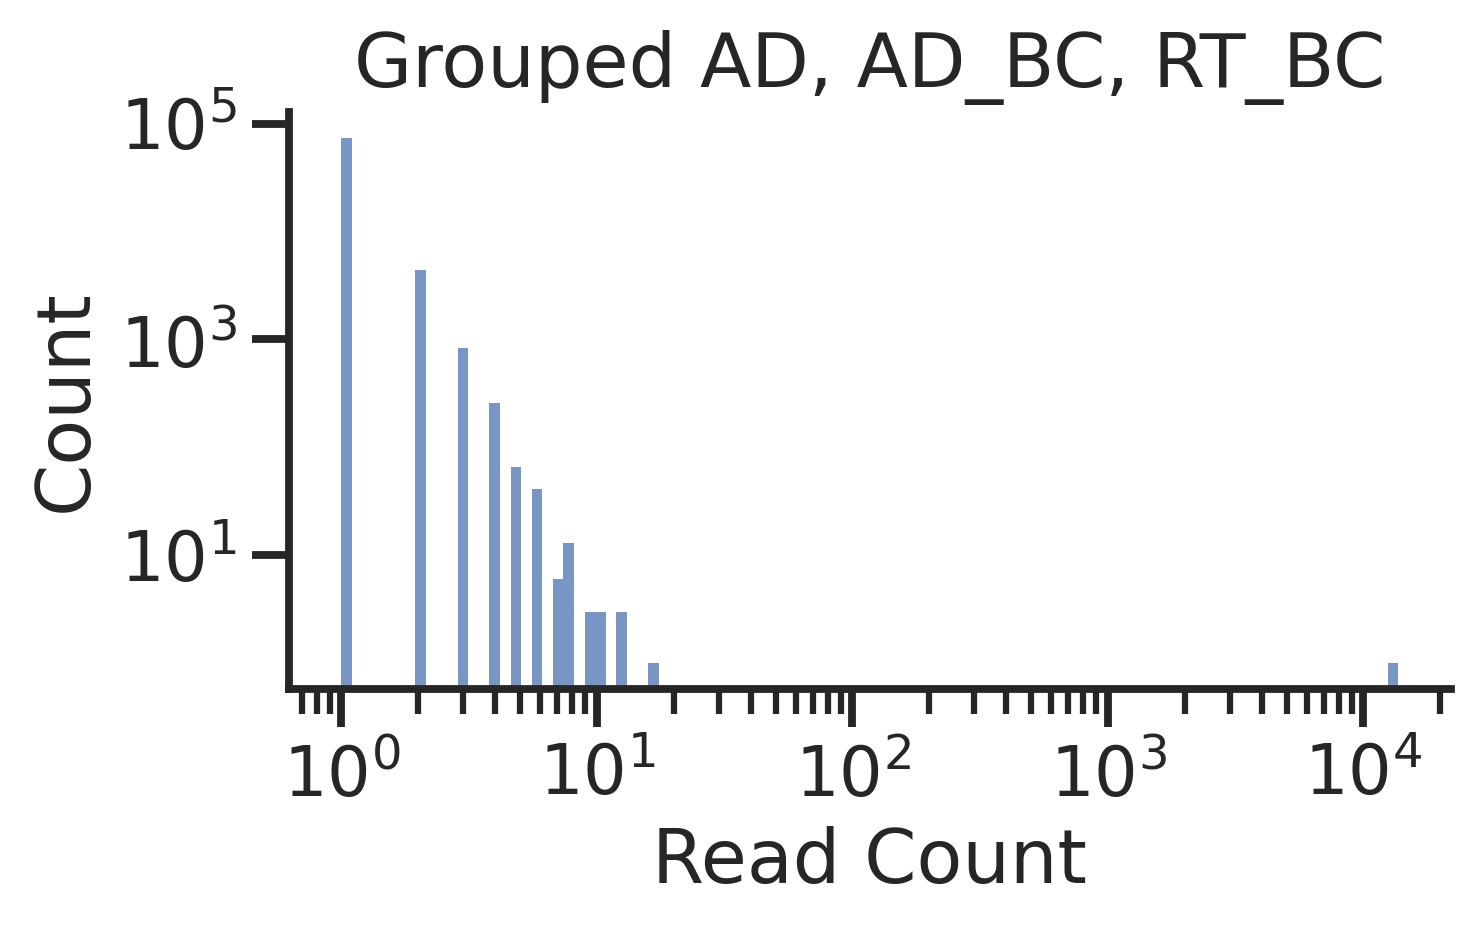

Done in 1.24 seconds.

Done.
Saved loss summary table as 'step1_AD_AD_BC_RT_BC_loss_summary'
Done in 0.08 seconds.



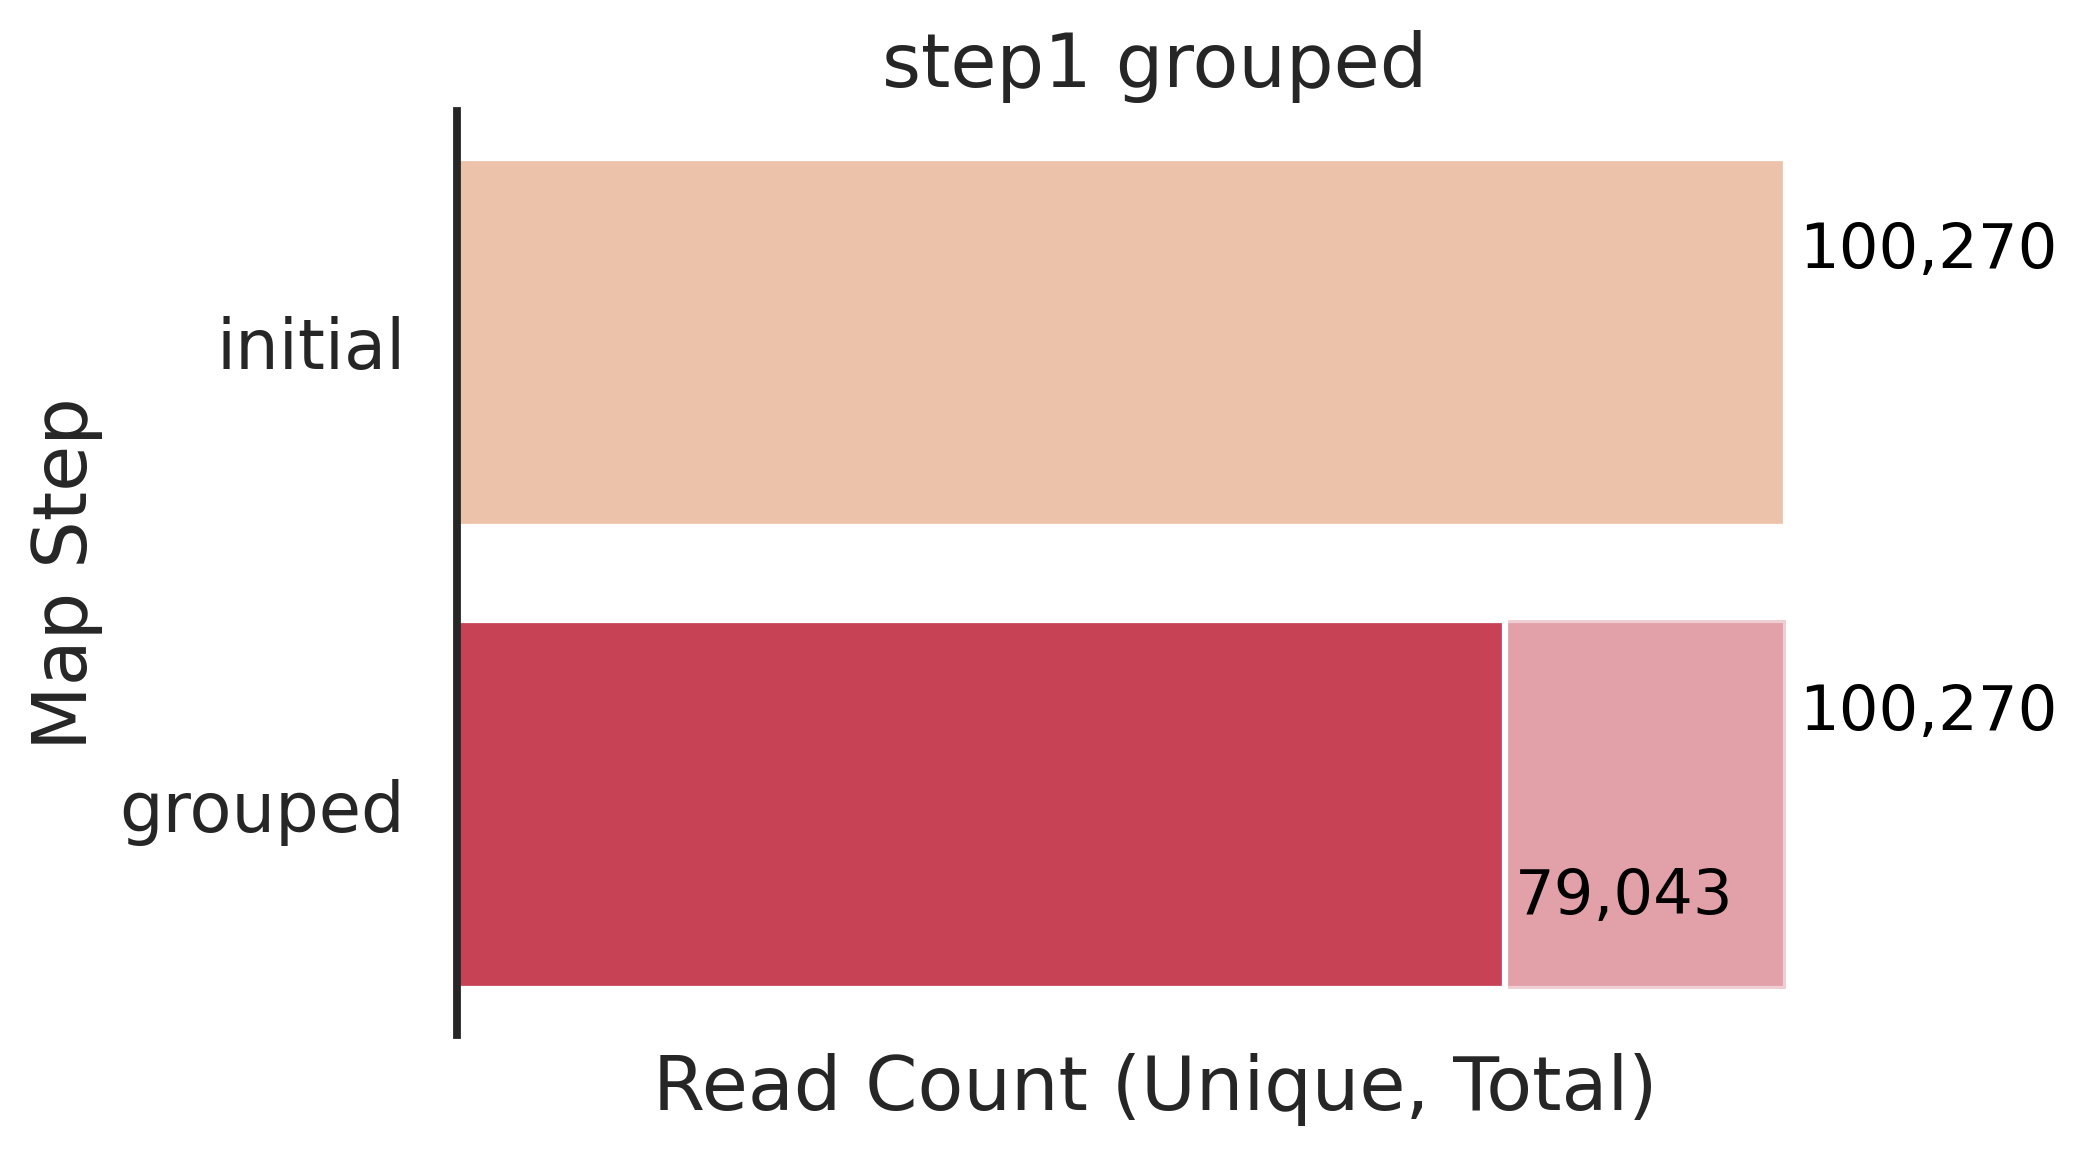

In [6]:
# Plot reads distribution
# NOTE: For large files (>10M reads), consider submitting this as a Savio job
# See examples/savio_jobs/quick_start_job.sh for job submission example

pipeline.step1_reads_distribution(
    seq_file=step1_seq_file, bc_objects=bc_objects, reverse_complement=True
)
# Produces histogram of reads per barcode
# Helps pick appropriate reads_threshold for filtering

✓ Initial map already exists: step1_AD_AD_BC_RT_BC_initial — skipping
Base prefix (stable across descriptors): step1_AD_AD_BC_RT_BC_
Full prefix for this instance: step1_AD_AD_BC_RT_BC_

Using the following step order:
1. initial
2. grouped
3. thresholded
4. barcode_exists
5. unique_target
6. quality
7. designed

Grouping step1_AD_AD_BC_RT_BC_initial...


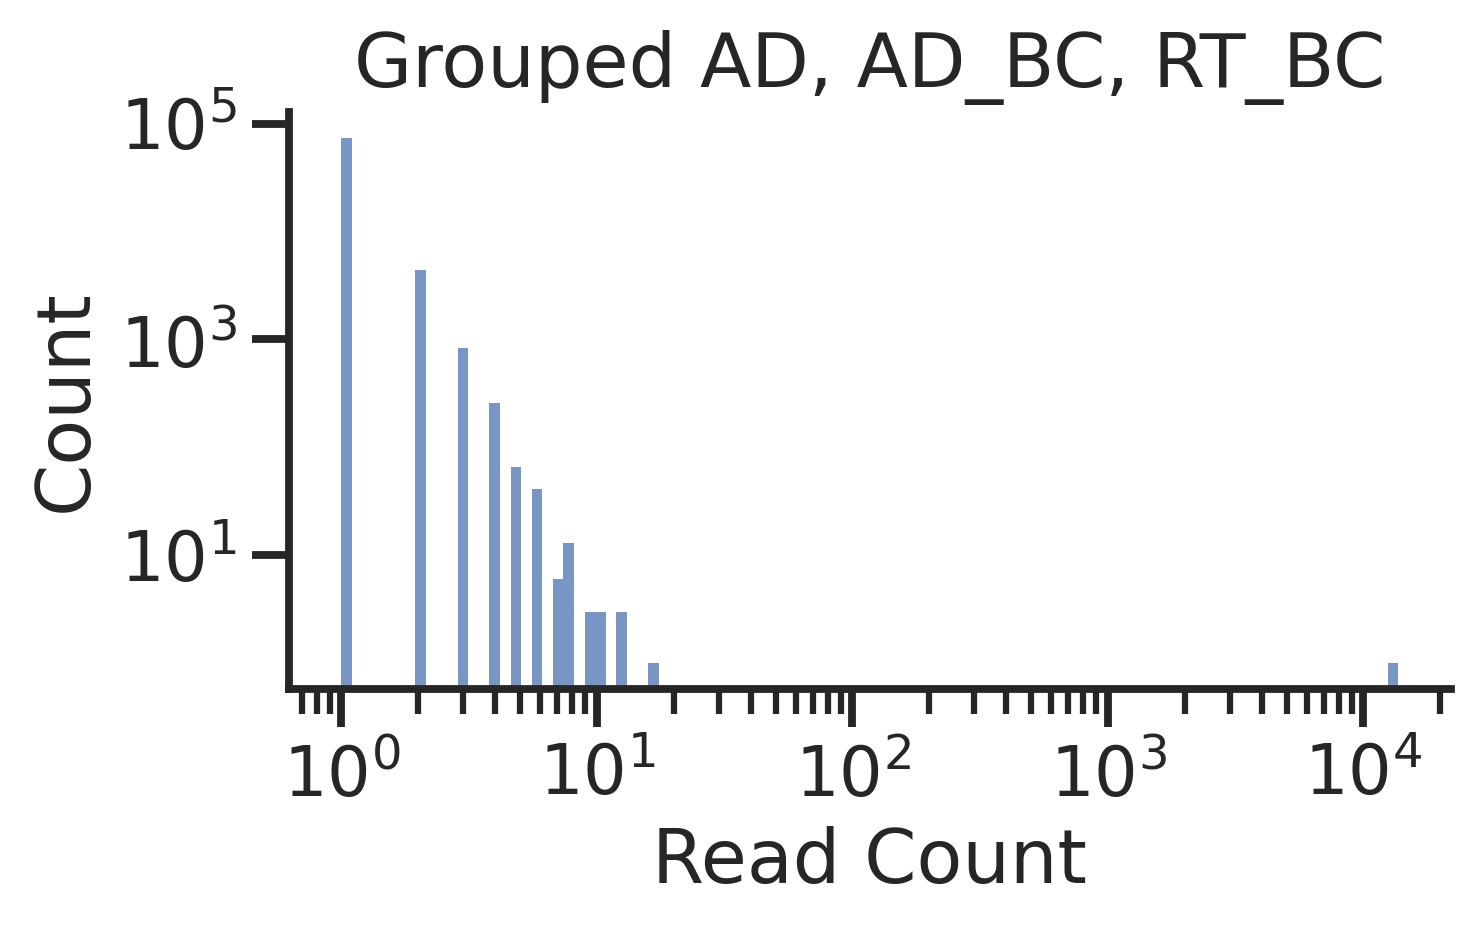

Done in 1.03 seconds.

Thresholding...
Using reads threshold of 1.


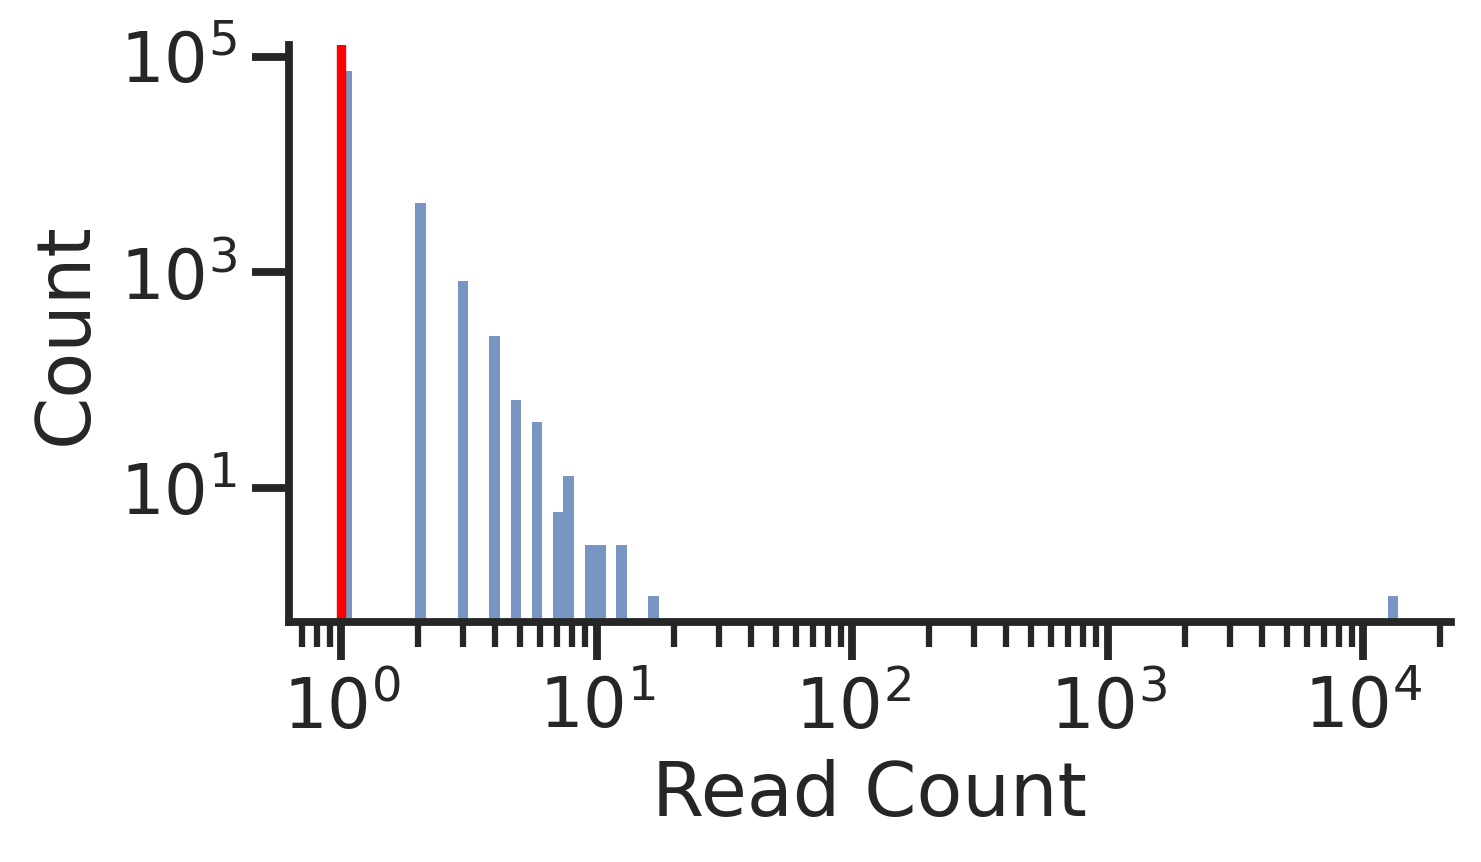

Done in 1.00 seconds.

Removing rows with null or empty barcodes (excluding AD)...
Done in 0.02 seconds.

Filtering so that at least 90% of reads come from the most abundant target...
	Processing mapping 1: RT_BC → AD
Created filtered table: step1_AD_AD_BC_RT_BC_unique_target
Done in 0.02 seconds.


Filtering to high-quality reads...
Created table: step1_AD_AD_BC_RT_BC_quality — filtered for TRUE in all *_qual columns.
Done in 0.00 seconds.


Filtering to designed sequences...
Created table: step1_AD_AD_BC_RT_BC_designed — kept only Designed == 1.
Done in 0.00 seconds.

Done.
Saved loss summary table as 'step1_AD_AD_BC_RT_BC_loss_summary'
Done in 0.09 seconds.



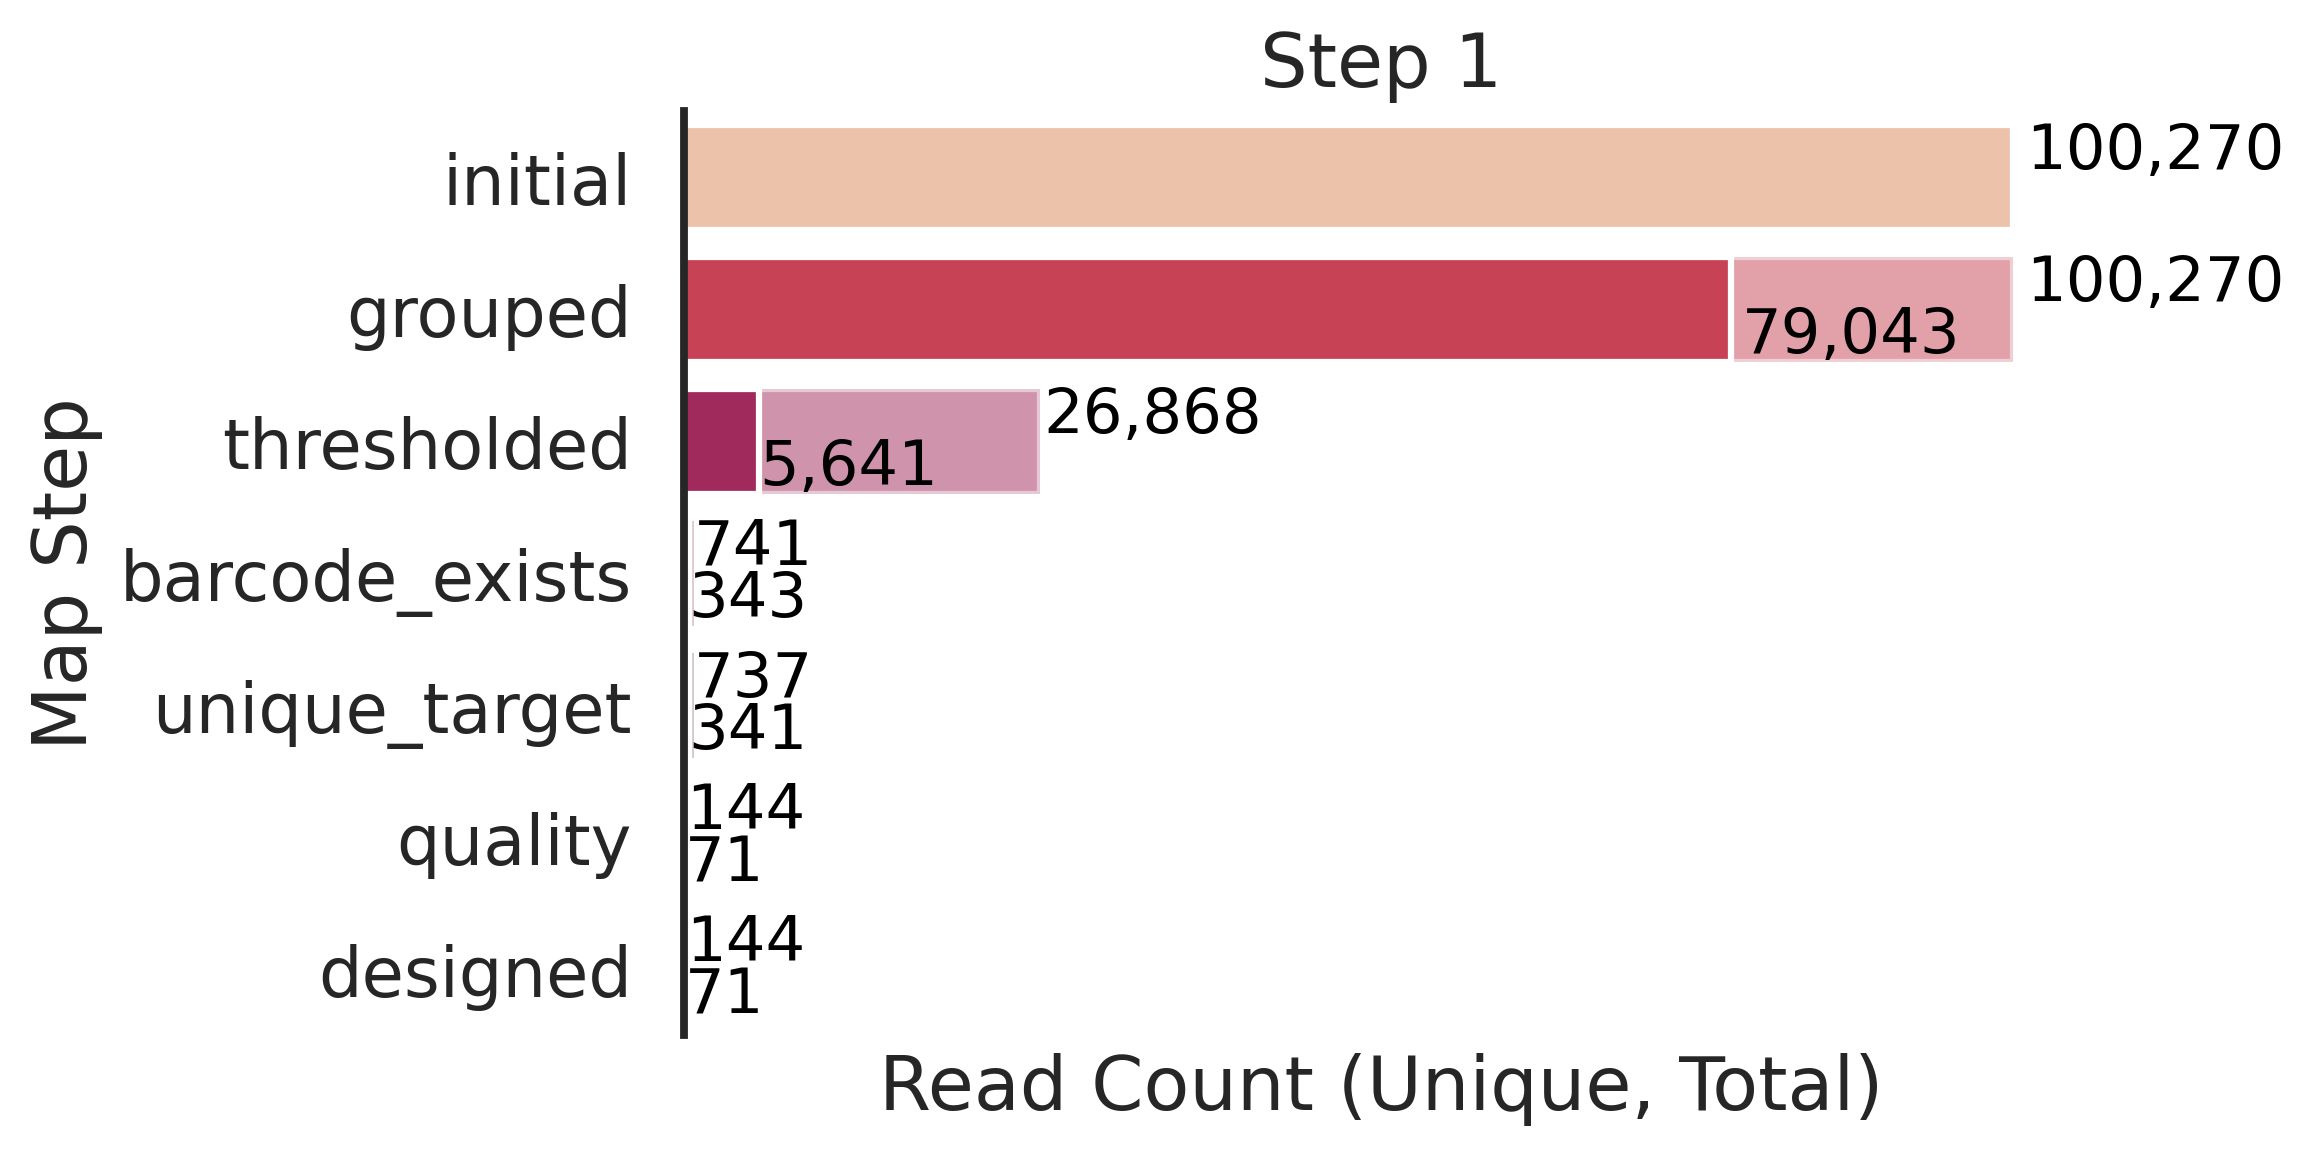

In [7]:
# Run Step 1 mapping
step1_map = pipeline.run_step_1(
    seq_file=step1_seq_file,
    bc_objects=bc_objects,
    column_pairs=[("RT_BC", "AD")],  # Check for collisions between RT_BC and AD
    reads_threshold=1,  # Minimum reads to keep a barcode
    reverse_complement=False,
)
# Returns DataFrame of Step 1 mapping
# Saves CSV, loss table visualization, and optional loss table CSV

## Step 2: TREBL Step 2 Mapping

Step 2 processes AD and RT libraries that are now in separate sequencing files.

**Note:** Step 1 must be completed successfully before running Step 2.

In [8]:
# Sequencing files for AD and RT (Step 2)
step2_AD_seq_file = "../data/step2_ChopTFs_AD_sample.fastq"
step2_RT_seq_file = "../data/step2_ChopTFs_RT_sample.fastq"
# Can be single files or lists of files; .fastq or .fastq.gz

Reading 1 FASTQ/TXT file(s)...
Done in 0.39 seconds.

Reverse complement of sequences...
Done in 1.58 seconds.

Extracting 2 barcodes...
AD: extracting between 'GGCTAGC' and 'TGACTAG'
AD_BC: extracting between 'CGCGCC' and 'GGGCCC'
Done in 1.26 seconds.

Done in 0.00 seconds.

Merging with design file...
Done in 0.61 seconds.

Mapping complete.
Base prefix (stable across descriptors): step2_AD_AD_BC_
Full prefix for this instance: step2_AD_AD_BC_

Using the following step order:
1. initial
2. grouped

Grouping step2_AD_AD_BC_initial...


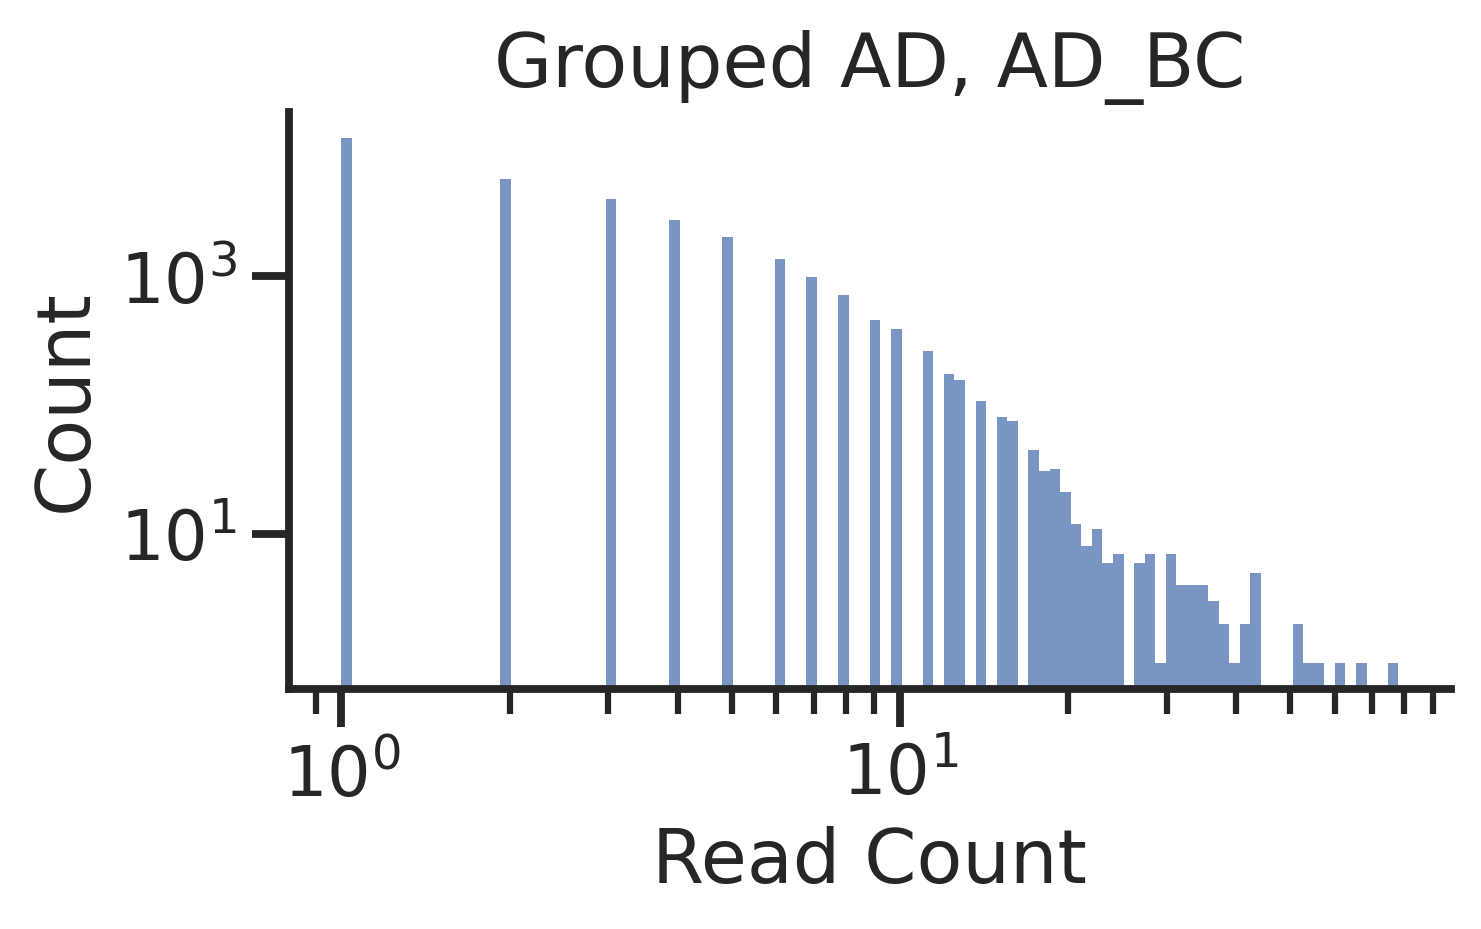

Done in 0.77 seconds.

Done.
Saved loss summary table as 'step2_AD_AD_BC_loss_summary'
Done in 0.05 seconds.

Reading 1 FASTQ/TXT file(s)...
Done in 0.34 seconds.

Reverse complement of sequences...
Done in 1.57 seconds.

Extracting 1 barcodes...
RT_BC: extracting between 'CTCGAG' and 'GGCCGC'
Done in 0.29 seconds.

Done in 0.00 seconds.

Done in 0.32 seconds.

Mapping complete.
Base prefix (stable across descriptors): step2_RT_BC_
Full prefix for this instance: step2_RT_BC_

Using the following step order:
1. initial
2. grouped

Grouping step2_RT_BC_initial...


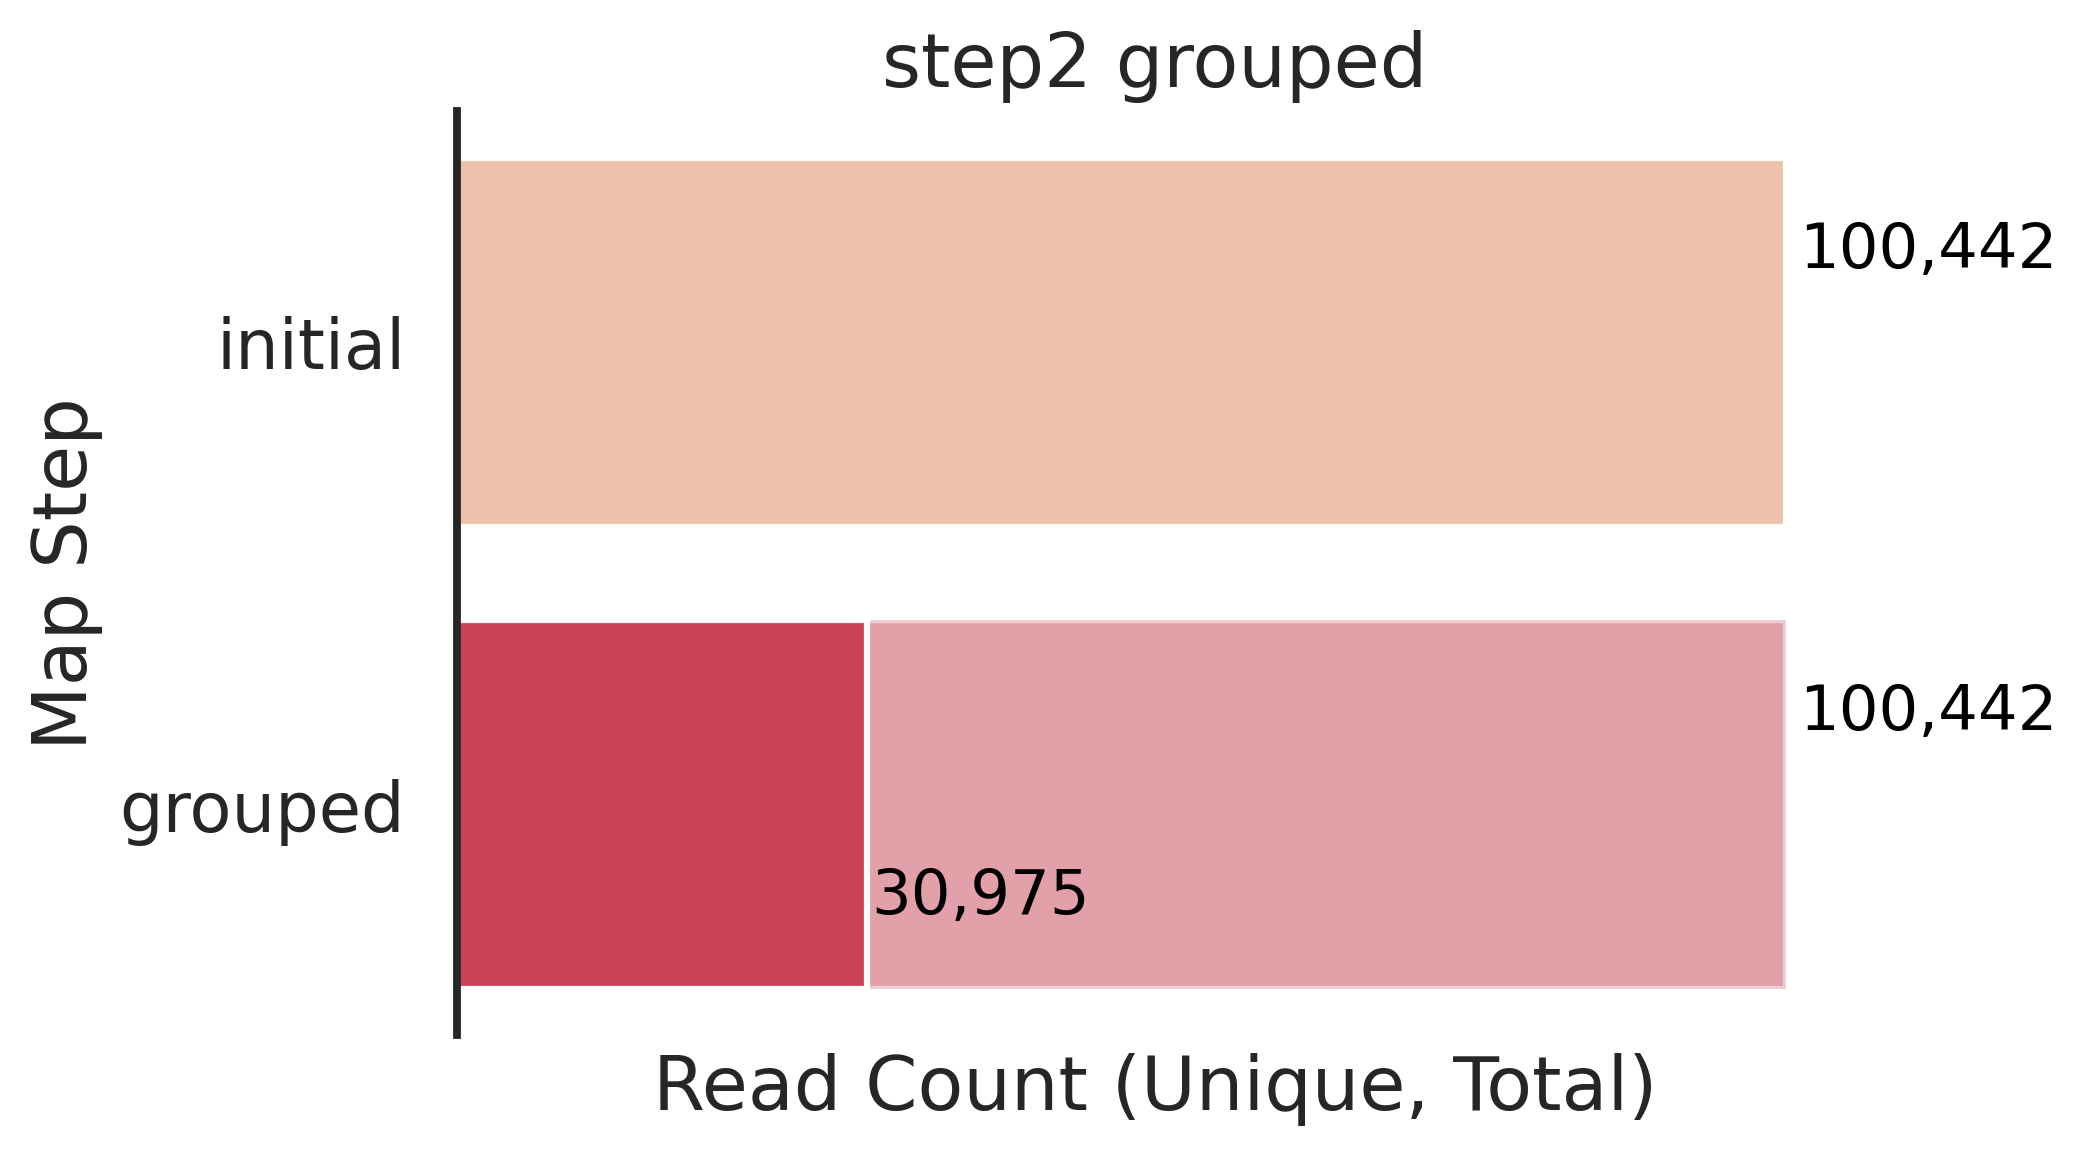

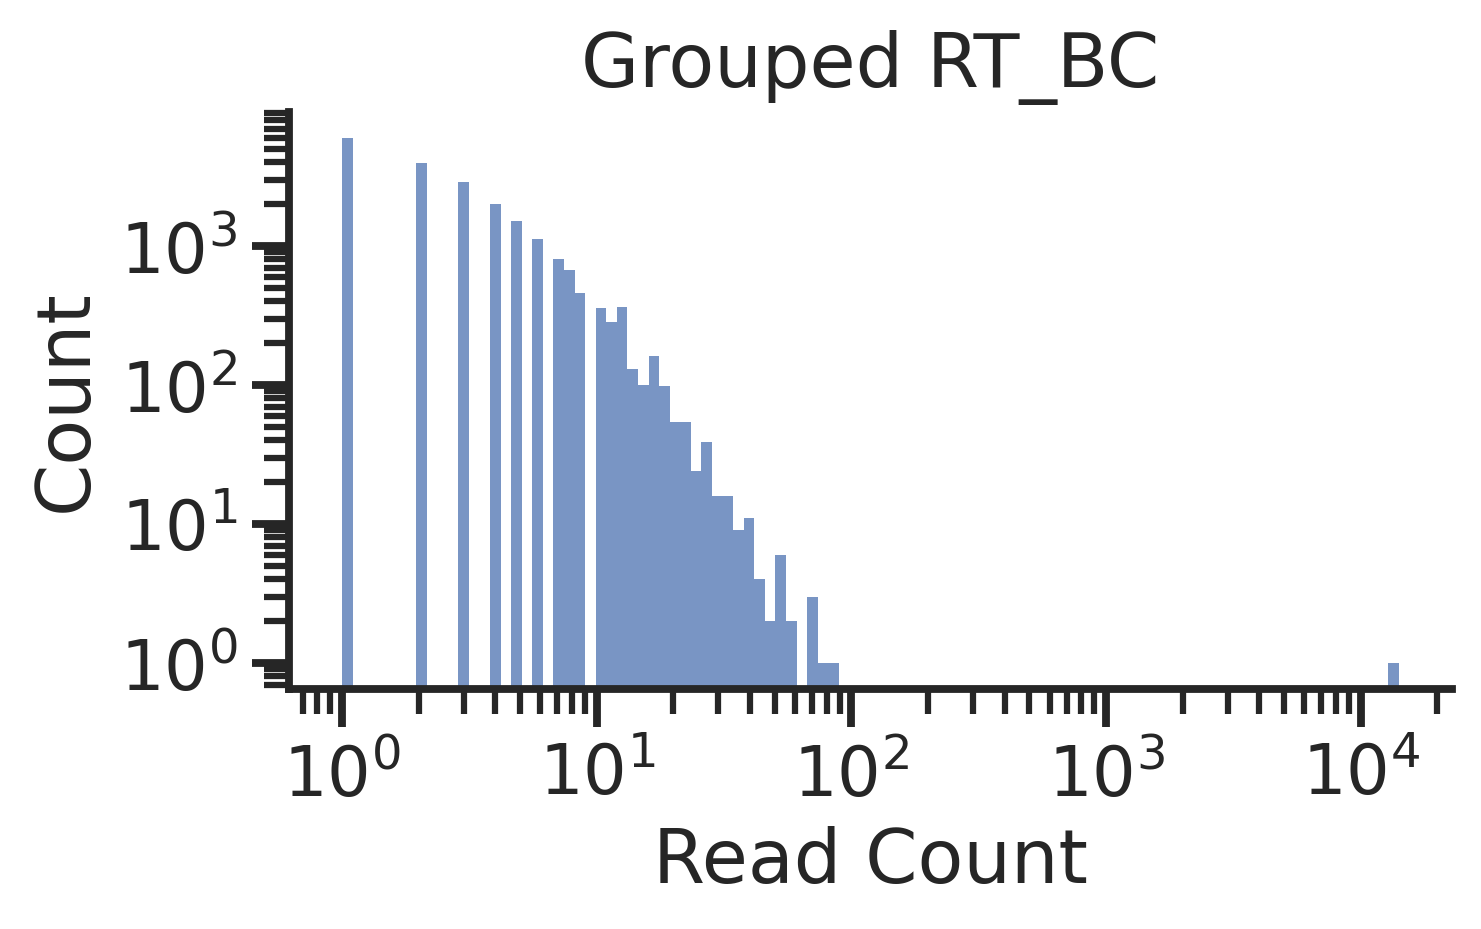

Done in 1.26 seconds.

Done.
Saved loss summary table as 'step2_RT_BC_loss_summary'
Done in 0.02 seconds.



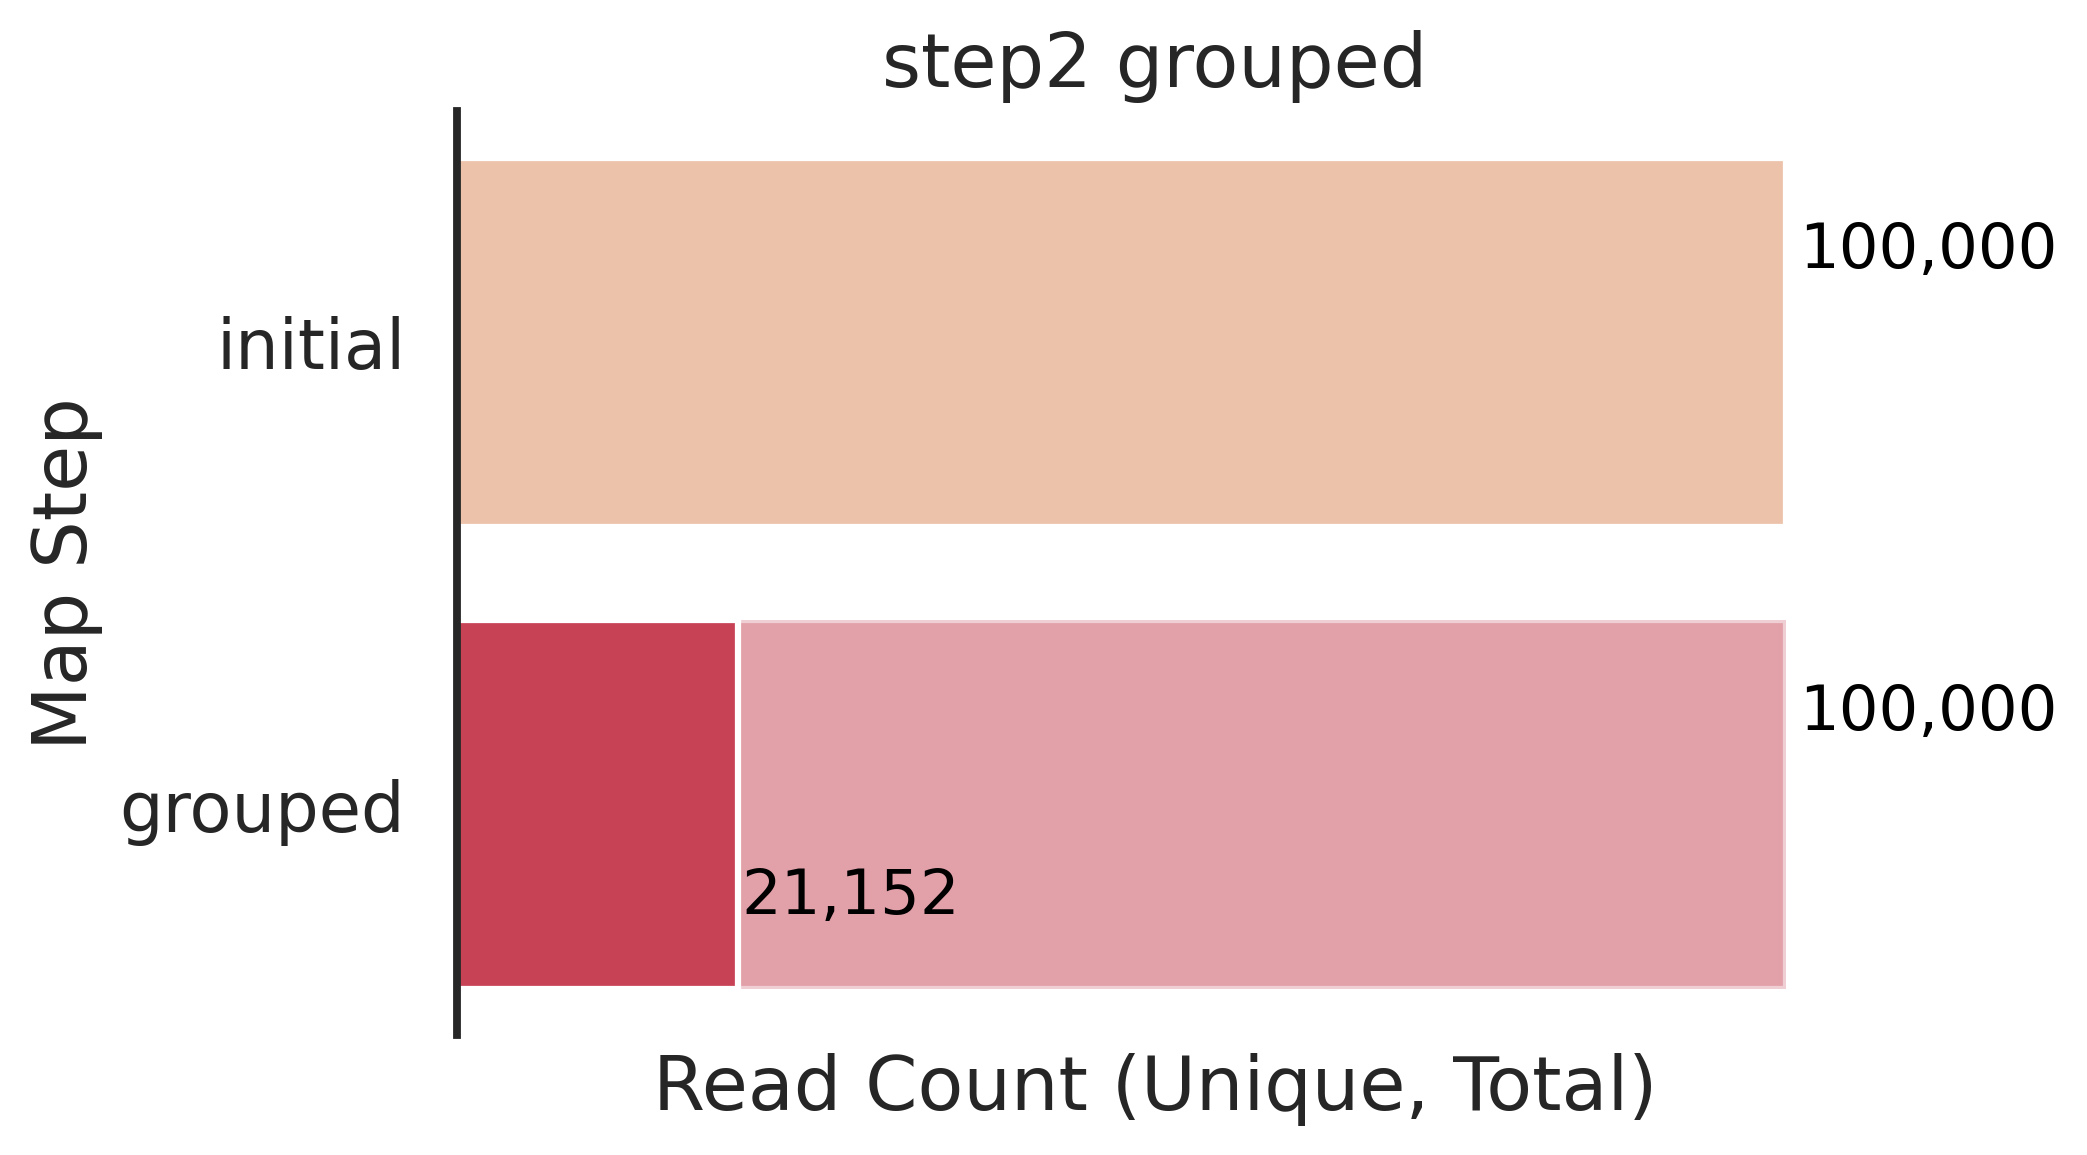

In [9]:
# Plot Step 2 reads distribution
# NOTE: For large files (>10M reads), consider submitting this as a Savio job

pipeline.step2_reads_distribution(
    AD_seq_file=step2_AD_seq_file,
    AD_bc_objects=AD_bc_objects,
    RT_seq_file=step2_RT_seq_file,
    RT_bc_objects=RT_bc_objects,
    reverse_complement=True,
)
# Produces histograms for AD and RT reads
# Helps pick reads_threshold_AD and reads_threshold_RT

✓ Initial map already exists: step2_AD_AD_BC_initial — skipping
✓ Initial map already exists: step2_RT_BC_initial — skipping
Base prefix (stable across descriptors): step2_AD_AD_BC_
Full prefix for this instance: step2_AD_AD_BC_

Using the following step order:
1. initial
2. grouped
3. thresholded
4. barcode_exists
5. quality
6. designed

Base prefix (stable across descriptors): step2_RT_BC_
Full prefix for this instance: step2_RT_BC_

Using the following step order:
1. initial
2. grouped
3. thresholded
4. barcode_exists
5. quality
6. designed

Grouping step2_AD_AD_BC_initial...


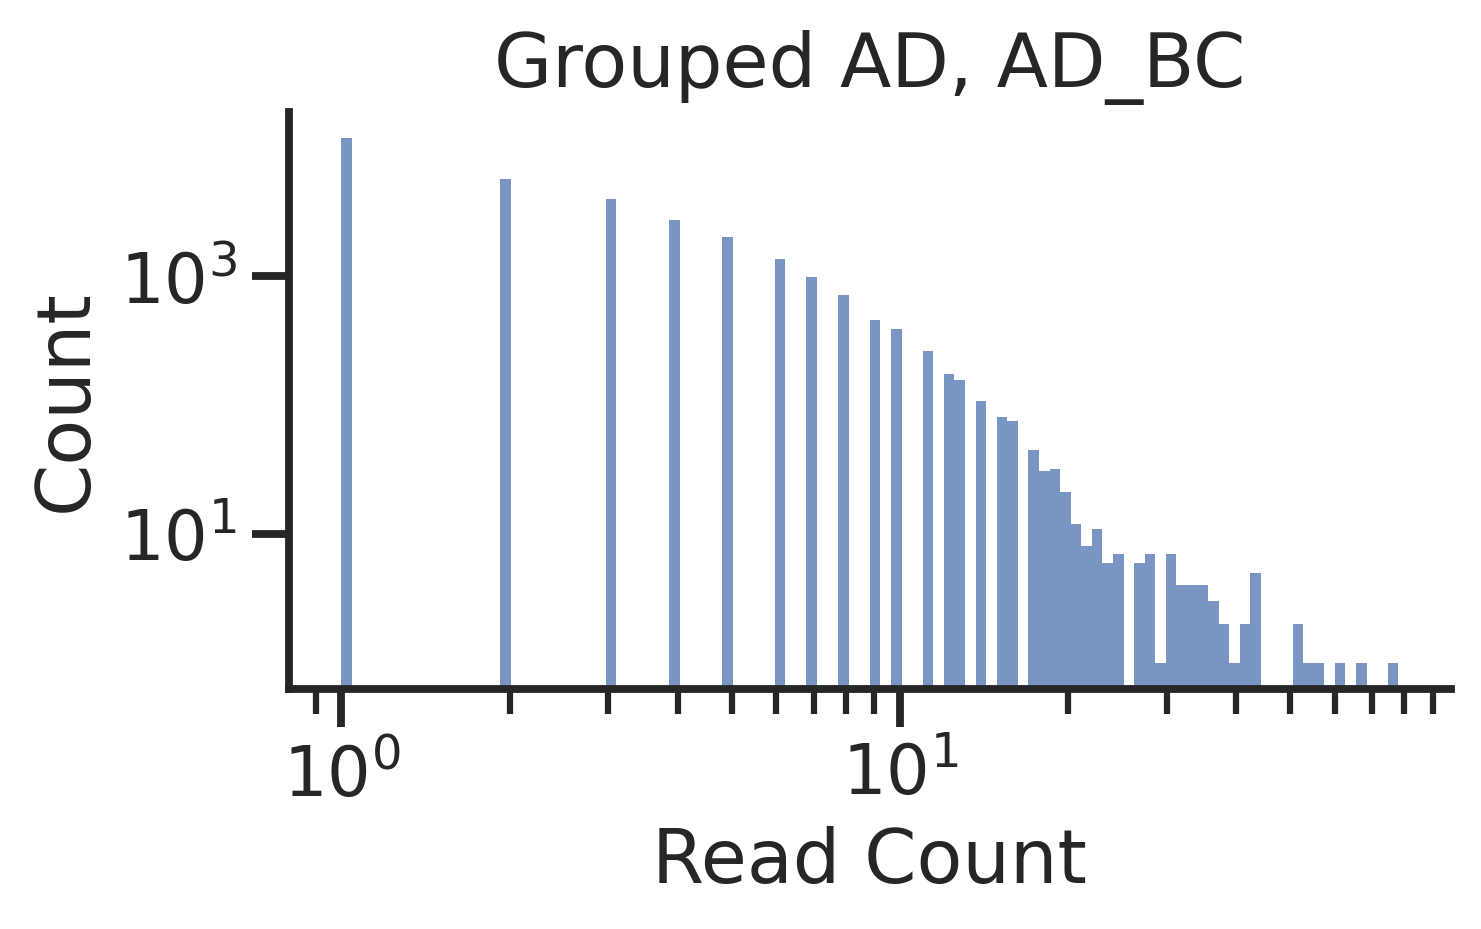

Done in 0.76 seconds.

Thresholding...
Using reads threshold of 1.


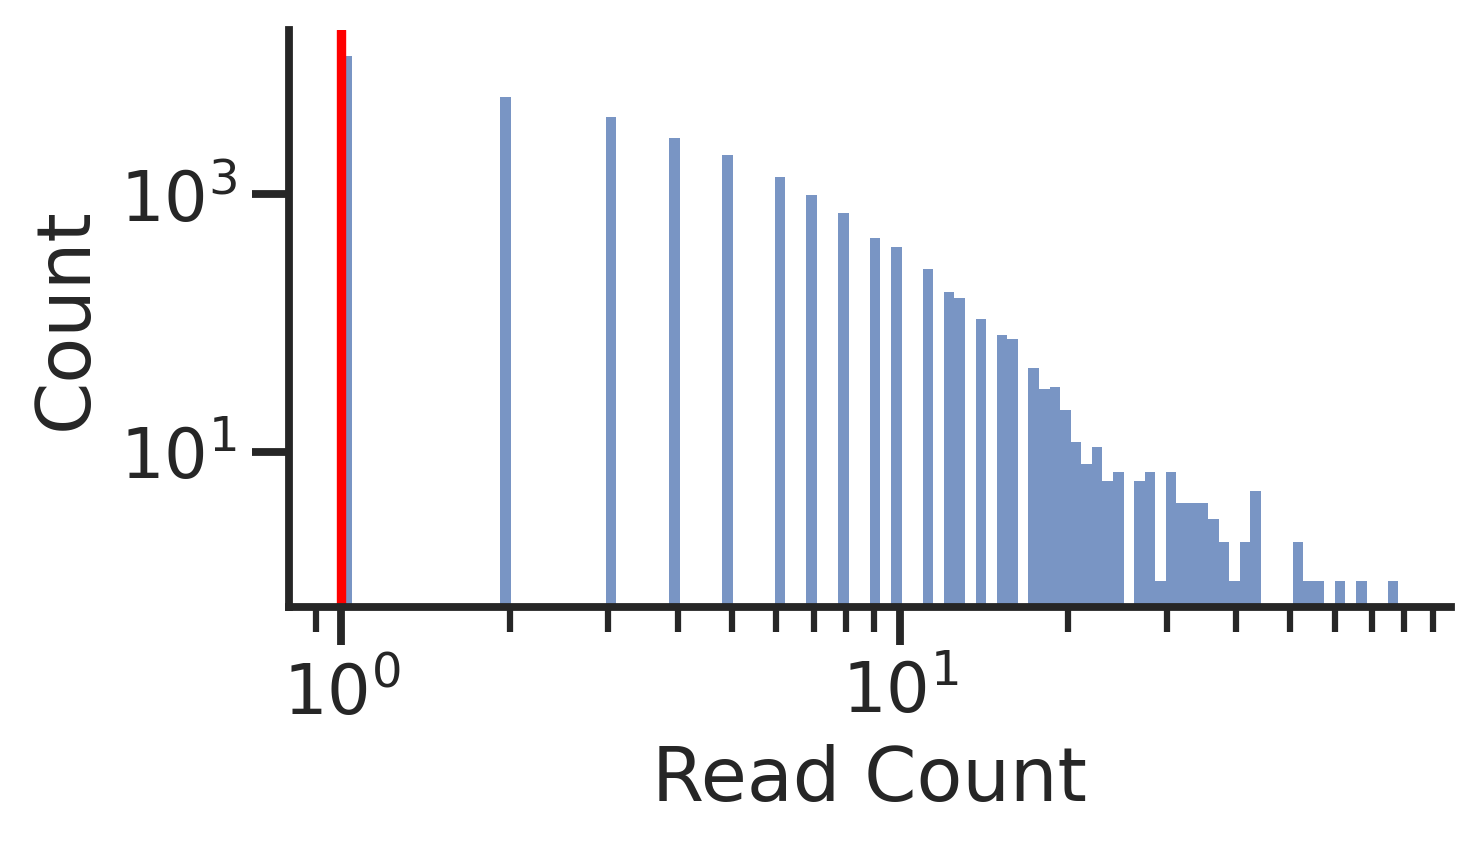

Done in 0.85 seconds.

Removing rows with null or empty barcodes (excluding AD)...
Done in 0.03 seconds.


Filtering to high-quality reads...
Created table: step2_AD_AD_BC_quality — filtered for TRUE in all *_qual columns.
Done in 0.01 seconds.


Filtering to designed sequences...
Created table: step2_AD_AD_BC_designed — kept only Designed == 1.
Done in 0.02 seconds.

Done.
Saved loss summary table as 'step2_AD_AD_BC_loss_summary'
Done in 0.07 seconds.

Grouping step2_RT_BC_initial...


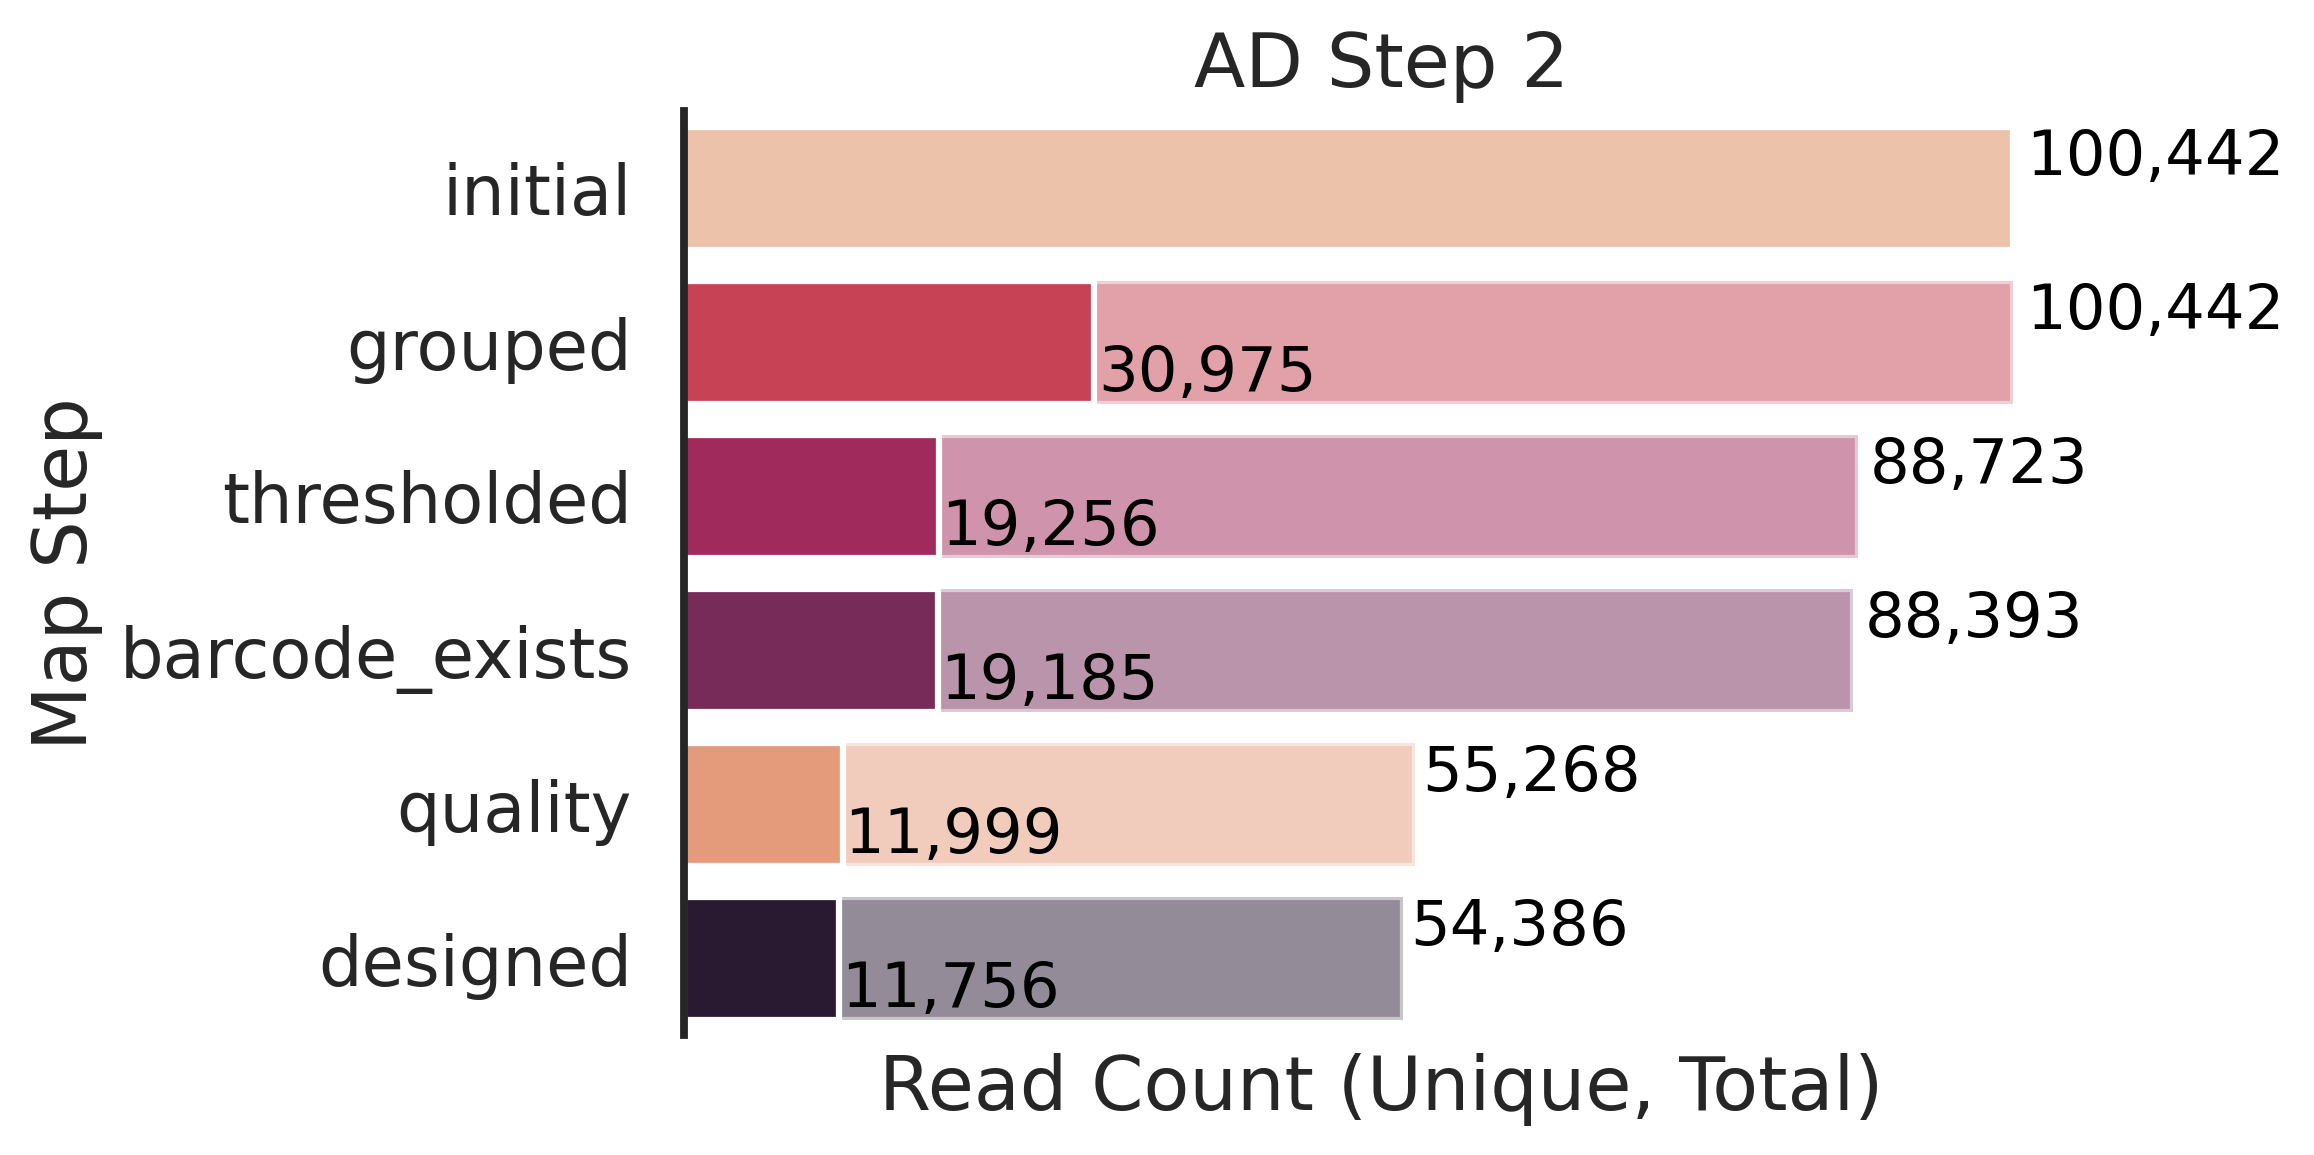

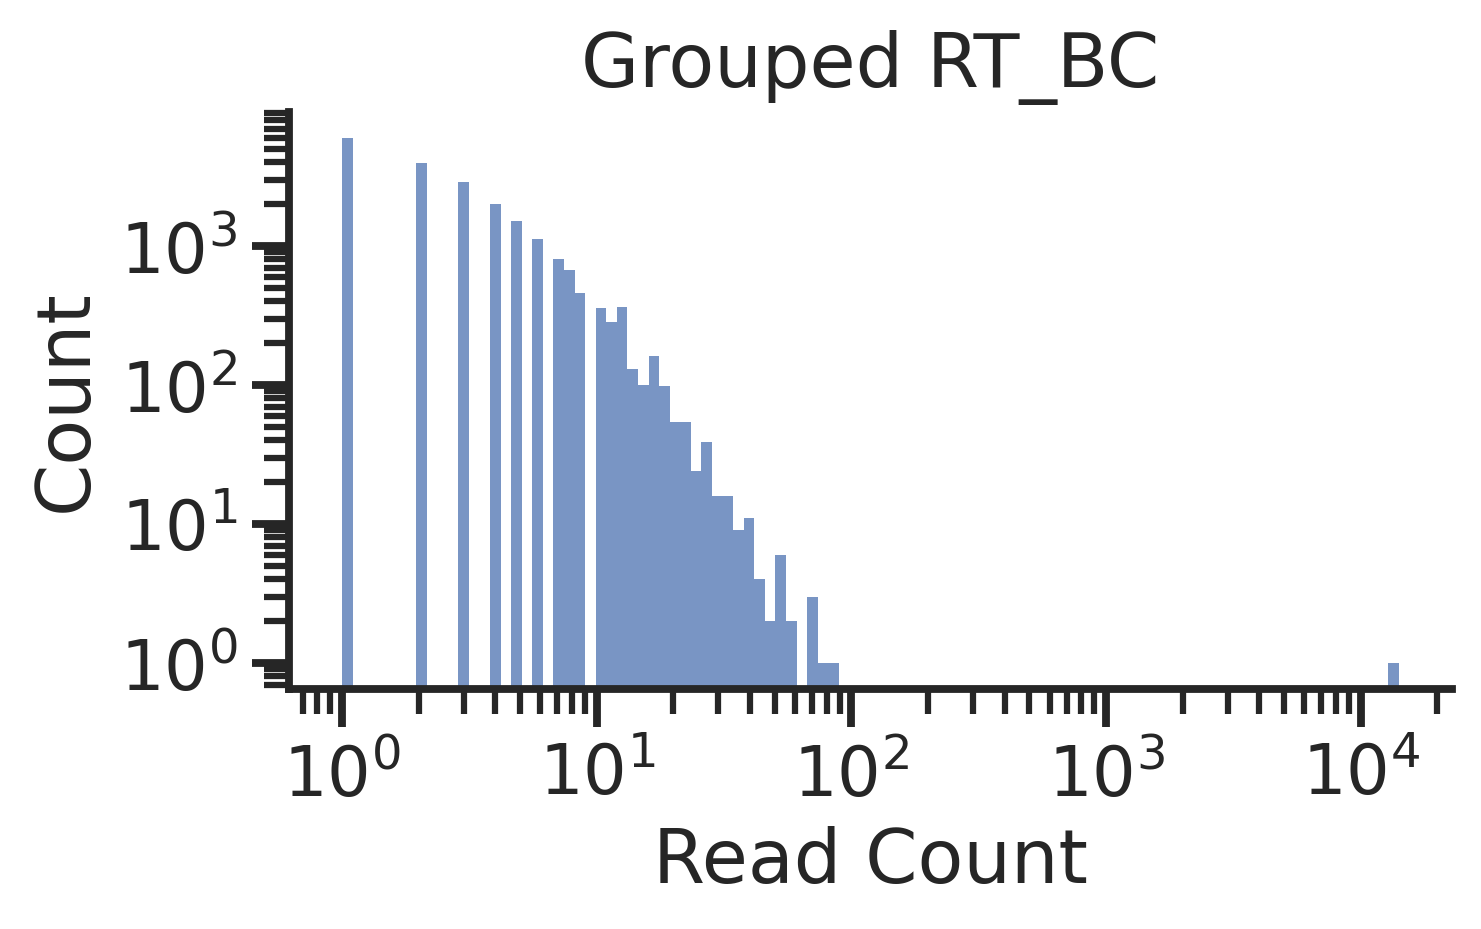

Done in 1.32 seconds.

Thresholding...
Using reads threshold of 1.


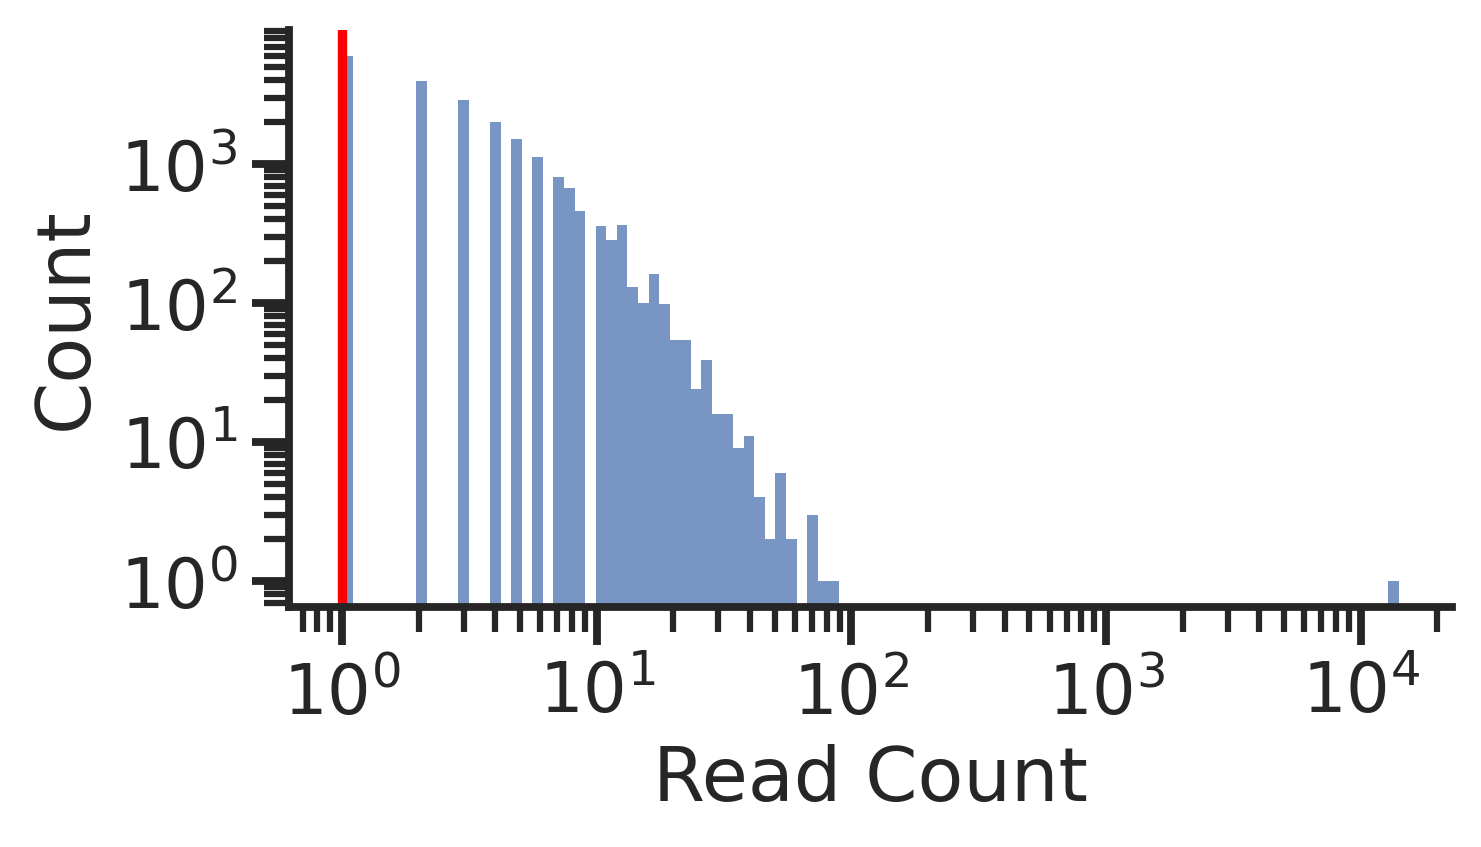

Done in 0.96 seconds.

Removing rows with null or empty barcodes (excluding AD)...
Done in 0.01 seconds.


Filtering to high-quality reads...
Created table: step2_RT_BC_quality — filtered for TRUE in all *_qual columns.
Done in 0.01 seconds.


Filtering to designed sequences...
Created table: step2_RT_BC_designed — kept only Designed == 1.
Done in 0.01 seconds.

Done.
Saved loss summary table as 'step2_RT_BC_loss_summary'
Done in 0.03 seconds.



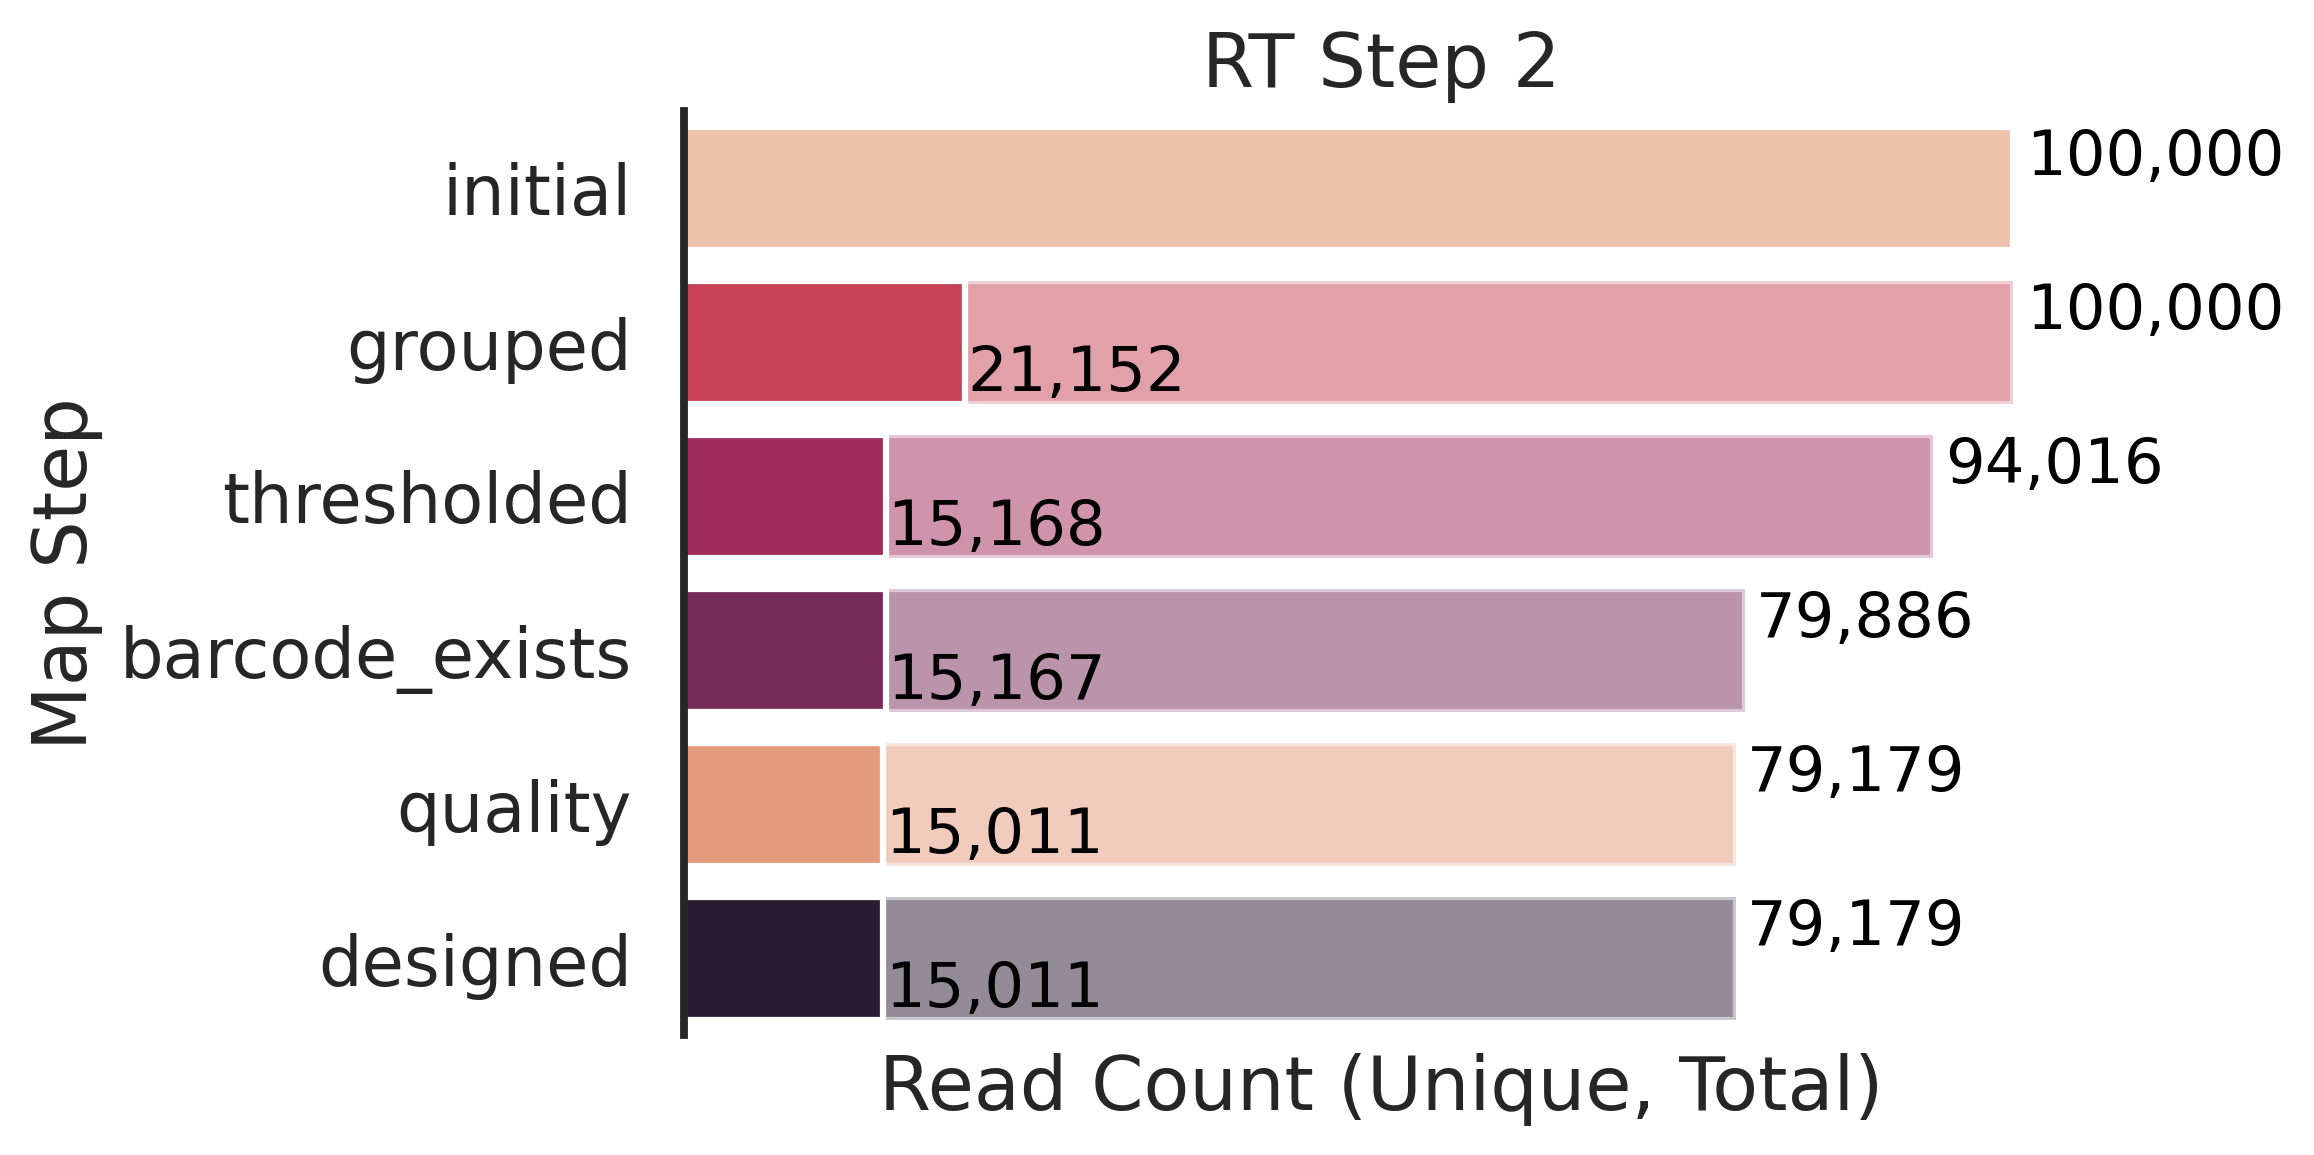

In [10]:
# Run Step 2 mapping
step2 = pipeline.run_step_2(
    AD_seq_file=step2_AD_seq_file,
    AD_bc_objects=AD_bc_objects,
    RT_seq_file=step2_RT_seq_file,
    RT_bc_objects=RT_bc_objects,
    reverse_complement=True,
    reads_threshold_AD=1,
    reads_threshold_RT=1,
    step1_map_csv_path="../output/quick_start/step1.csv",  # Update with your step1 CSV path
)

# Extract outputs
AD_step2 = step2["AD_step2"]
RT_step2 = step2["RT_step2"]
step1_overlap = step2["step1_overlap"]

In [11]:
# AD ADBC pairs seen in step 2
AD_step2

,AD,AD_BC,count,AD_qual,AD_BC_qual,Designed
0,GGTTCTGCTAATAGAGCTAGATCTCCATTGCATTCTAATTCTAATA...,AACGTGAGAAC,62,True,True,1
1,ACTGCTATGGAAGCTTATACTCCAGAAAGAGGTTCTGCTAATAGAG...,GCAGTTTACGG,56,True,True,1
2,AATACTCCAGCTAATGTTATTGCTACTGATGCTACTAAATATGAAA...,ACCCCCGCTAT,51,True,True,1
3,ACTGCTATGGAAGCTTATACTCCAGAAAGAGGTTCTGCTAATAGAG...,ACTTCACTCTC,51,True,True,1
4,GGTTCTGCTAATAGAGCTAGATCTCCATTGCATTCTAATTCTAATA...,ACGGTCGTGAA,44,True,True,1
...,...,...,...,...,...,...
11751,GGTGAATCTGATGAAGAAGAAGAAGAAGGTGAAGAAGAAAGAAGAA...,ACTGTAGCTGA,2,True,True,1
11752,TCTGATTATAATTCTTTGGGTGAATCTTCTACTTCTTCTGCTCCAT...,GAGCTCATTGC,2,True,True,1
11753,AATTCTTCTAATATGGTTATCTTGCCATTGCCATCTCCATCTAATA...,TCTCCCCAGAC,2,True,True,1
11754,ATTTCTTATCATCAATTTCATGCTTATCAAACTGCTAACTTCTTGC...,GACACAAACTA,2,True,True,1


In [12]:
# RT BCs seen in step 2
RT_step2

,RT_BC,count,RT_BC_qual,Designed
0,GGGACGCCTGTCCT,85,True,1
1,ACCTCGTTCTCATC,75,True,1
2,GGGACGGTGTGAGT,73,True,1
3,TACACTTCATCTCC,73,True,1
4,CTAGGGTATGCCTT,67,True,1
...,...,...,...,...
15006,GAGGACACTGAACG,2,True,1
15007,ATACGAAATTTGCA,2,True,1
15008,ACTACGAACTAACC,2,True,1
15009,TATGCTTACCAGCA,2,True,1


In [13]:
# Overlap of step 1 map and step 2
step1_overlap

,BC_type,map_unique,step2,seen_in_both,percent_of_map_seen
0,"AD,AD_BC",71,11756,8,11.268
1,RT_BC,71,15011,3,4.225


## TREBL Experiment with Simple UMI Deduplication

Process the full TREBL experiment using simple UMI deduplication only.

In [14]:
# Define UMI objects
AD_UMI = finder.Barcode(name="UMI", preceder="TGATTT", post="", length=12)

RT_UMI = finder.Barcode(name="UMI", preceder="TGTCAC", post="", length=12)

In [15]:
# Collect sequencing files
trebl_AD_seq_files = [
    "../data/trebl_experiment_ChopTFs_AD_t10_r2.fastq",
    "../data/trebl_experiment_ChopTFs_AD_t60_r2.fastq",
]
trebl_RT_seq_files = [
    "../data/trebl_experiment_ChopTFs_RT_t10_r2.fastq",
    "../data/trebl_experiment_ChopTFs_RT_t60_r2.fastq",
]

Reading 1 FASTQ/TXT file(s)...
Done in 0.57 seconds.

Reverse complement of sequences...
Done in 0.86 seconds.

Extracting 2 barcodes...
AD: extracting between 'GGCTAGC' and 'TGACTAG'
AD_BC: extracting between 'CGCGCC' and 'GGGCCC'
Done in 0.84 seconds.

Extracting UMI...
UMI: extracting 12 bases after preceder 'TGATTT'
Done in 0.13 seconds.

Merging with design file...
Done in 0.47 seconds.

Mapping complete.
Base prefix (stable across descriptors): trebl_experiment_trebl_experiment_ChopTFs_AD_t10_r2_AD_AD_BC_
Full prefix for this instance: trebl_experiment_trebl_experiment_ChopTFs_AD_t10_r2_AD_AD_BC_

Using the following step order:
1. initial
2. quality


Filtering to high-quality reads...
Created table: trebl_experiment_trebl_experiment_ChopTFs_AD_t10_r2_AD_AD_BC_quality — filtered for TRUE in all *_qual columns.
Done in 0.04 seconds.

Done.
Saved loss summary table as 'trebl_experiment_trebl_experiment_ChopTFs_AD_t10_r2_AD_AD_BC_loss_summary'
Done in 0.04 seconds.



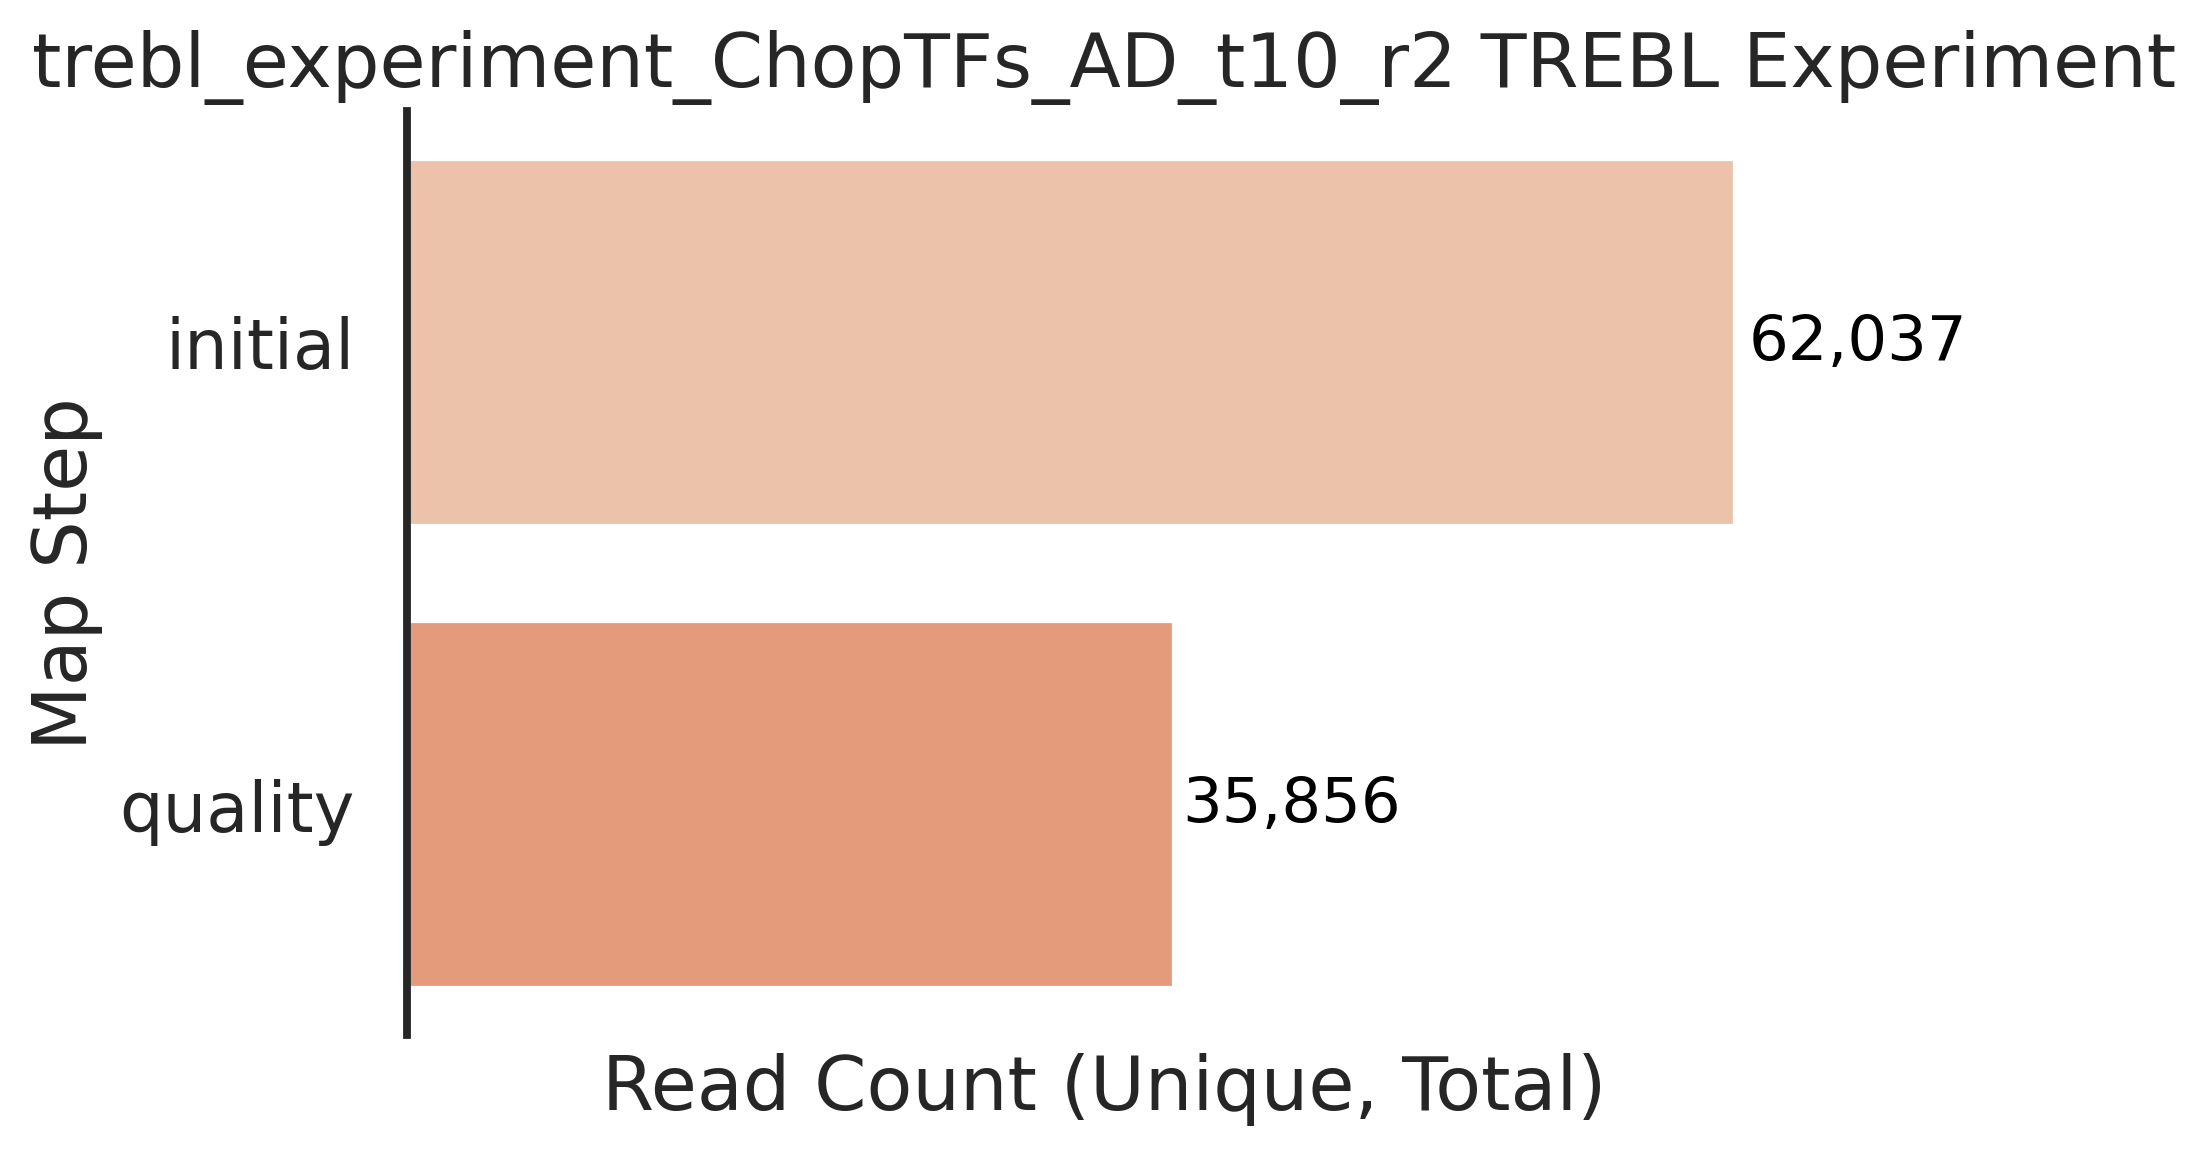

Saved to ../output/quick_start/trebl_experiment_trebl_experiment_ChopTFs_AD_t10_r2/trebl_experiment_ChopTFs_AD_t10_r2_simple_umi_counts.tsv
Saved to ../output/quick_start/trebl_experiment_trebl_experiment_ChopTFs_AD_t10_r2/trebl_experiment_ChopTFs_AD_t10_r2_reads_per_umi.tsv
Done in 0.25 seconds.

Reading 1 FASTQ/TXT file(s)...
Done in 0.23 seconds.

Reverse complement of sequences...
Done in 1.19 seconds.

Extracting 2 barcodes...
AD: extracting between 'GGCTAGC' and 'TGACTAG'
AD_BC: extracting between 'CGCGCC' and 'GGGCCC'
Done in 0.62 seconds.

Extracting UMI...
UMI: extracting 12 bases after preceder 'TGATTT'
Done in 0.13 seconds.

Merging with design file...
Done in 0.55 seconds.

Mapping complete.
Base prefix (stable across descriptors): trebl_experiment_trebl_experiment_ChopTFs_AD_t60_r2_AD_AD_BC_
Full prefix for this instance: trebl_experiment_trebl_experiment_ChopTFs_AD_t60_r2_AD_AD_BC_

Using the following step order:
1. initial
2. quality


Filtering to high-quality reads...

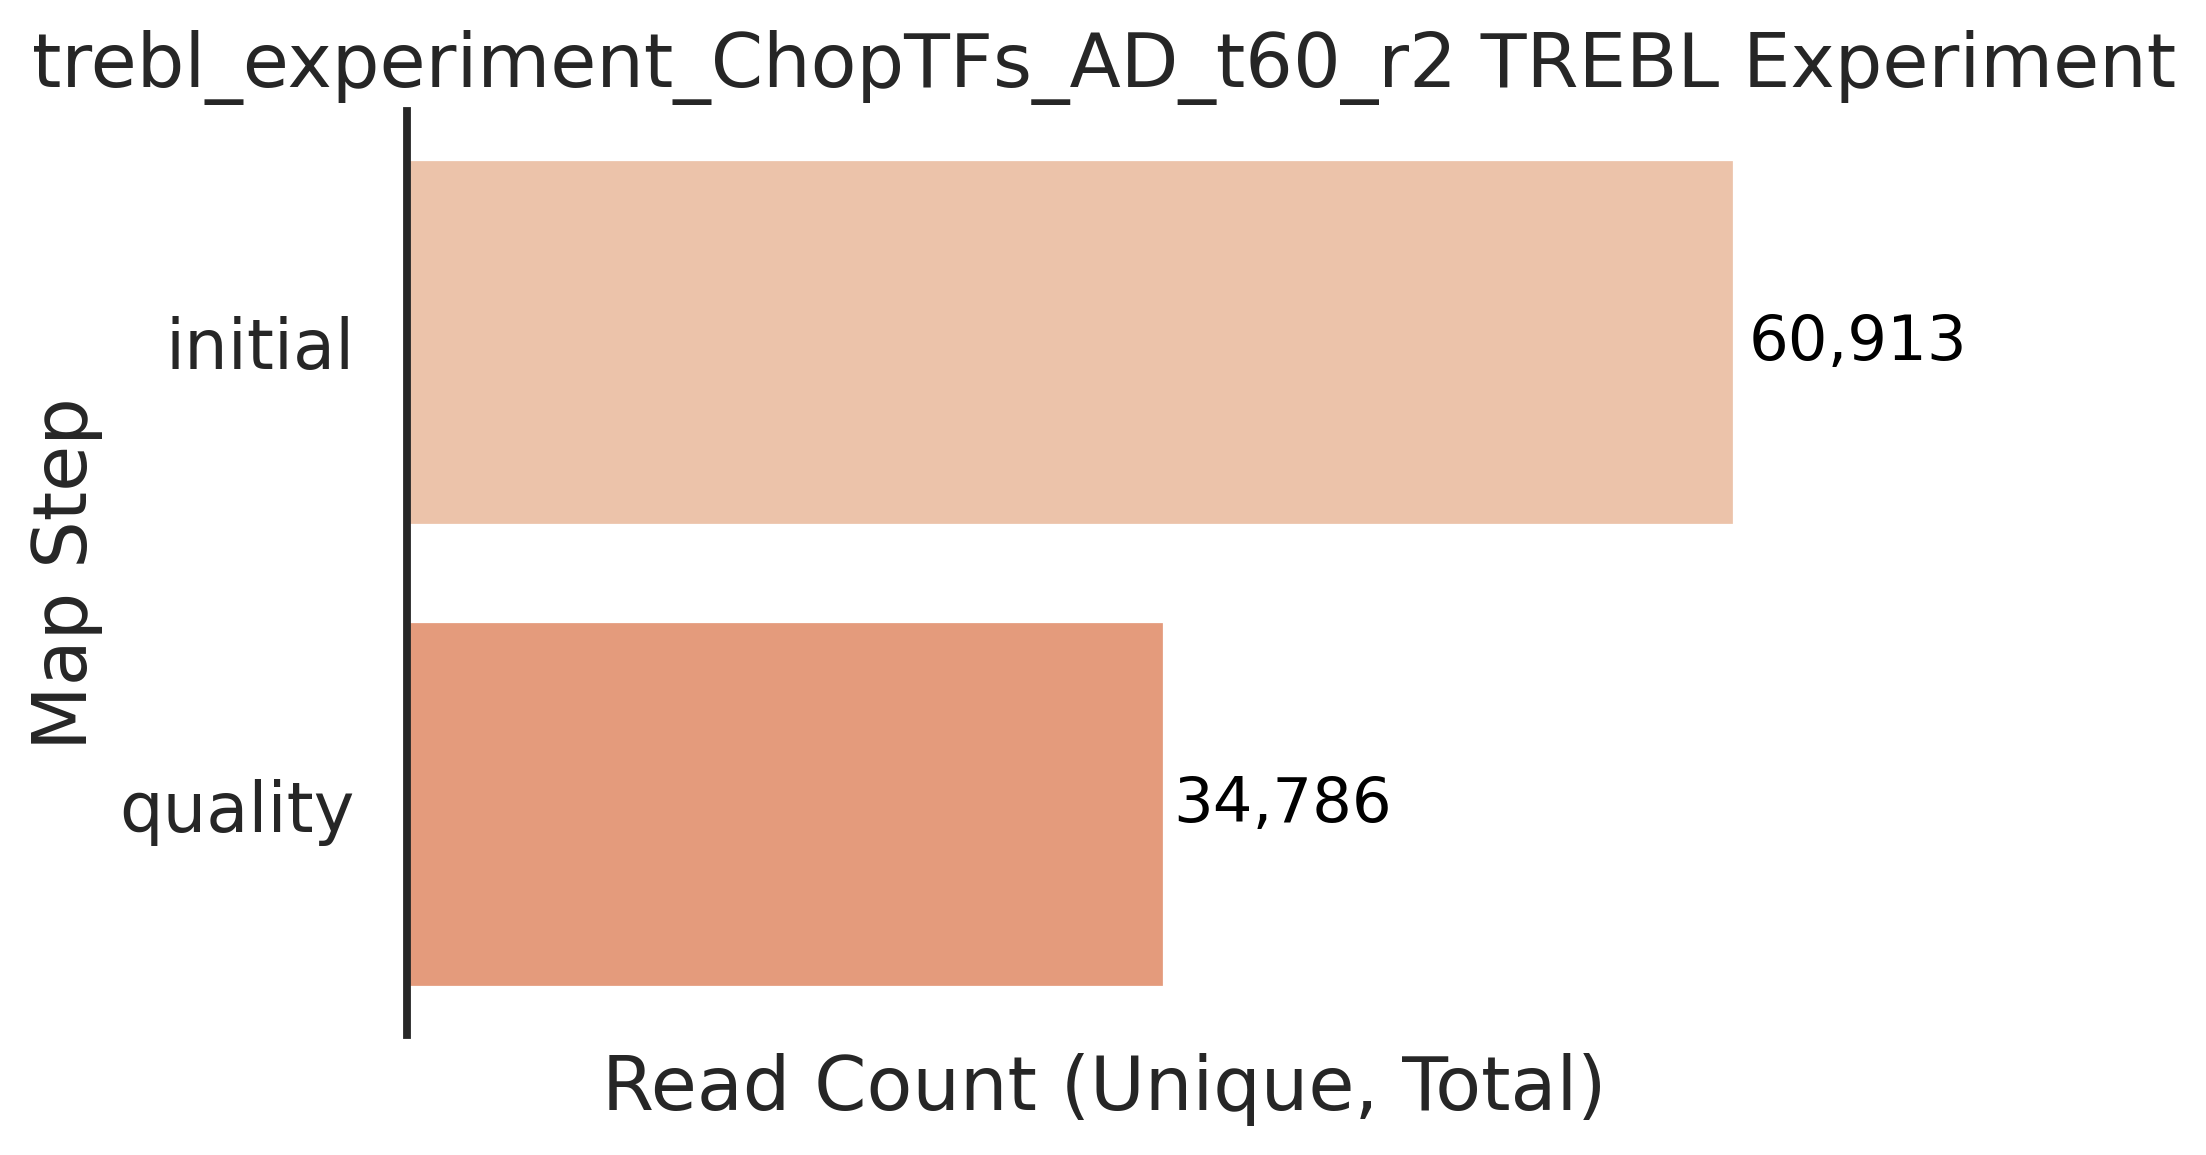

Saved to ../output/quick_start/trebl_experiment_trebl_experiment_ChopTFs_AD_t60_r2/trebl_experiment_ChopTFs_AD_t60_r2_simple_umi_counts.tsv
Saved to ../output/quick_start/trebl_experiment_trebl_experiment_ChopTFs_AD_t60_r2/trebl_experiment_ChopTFs_AD_t60_r2_reads_per_umi.tsv
Done in 0.26 seconds.

Reading 1 FASTQ/TXT file(s)...
Done in 0.18 seconds.

Reverse complement of sequences...
Done in 0.75 seconds.

Extracting 1 barcodes...
RT_BC: extracting between 'CTCGAG' and 'GGCCGC'
Done in 0.12 seconds.

Extracting UMI...
UMI: extracting 12 bases after preceder 'TGTCAC'
Done in 0.07 seconds.

Done in 0.07 seconds.

Mapping complete.
Base prefix (stable across descriptors): trebl_experiment_trebl_experiment_ChopTFs_RT_t10_r2_RT_BC_
Full prefix for this instance: trebl_experiment_trebl_experiment_ChopTFs_RT_t10_r2_RT_BC_

Using the following step order:
1. initial
2. quality


Filtering to high-quality reads...
Created table: trebl_experiment_trebl_experiment_ChopTFs_RT_t10_r2_RT_BC_quality

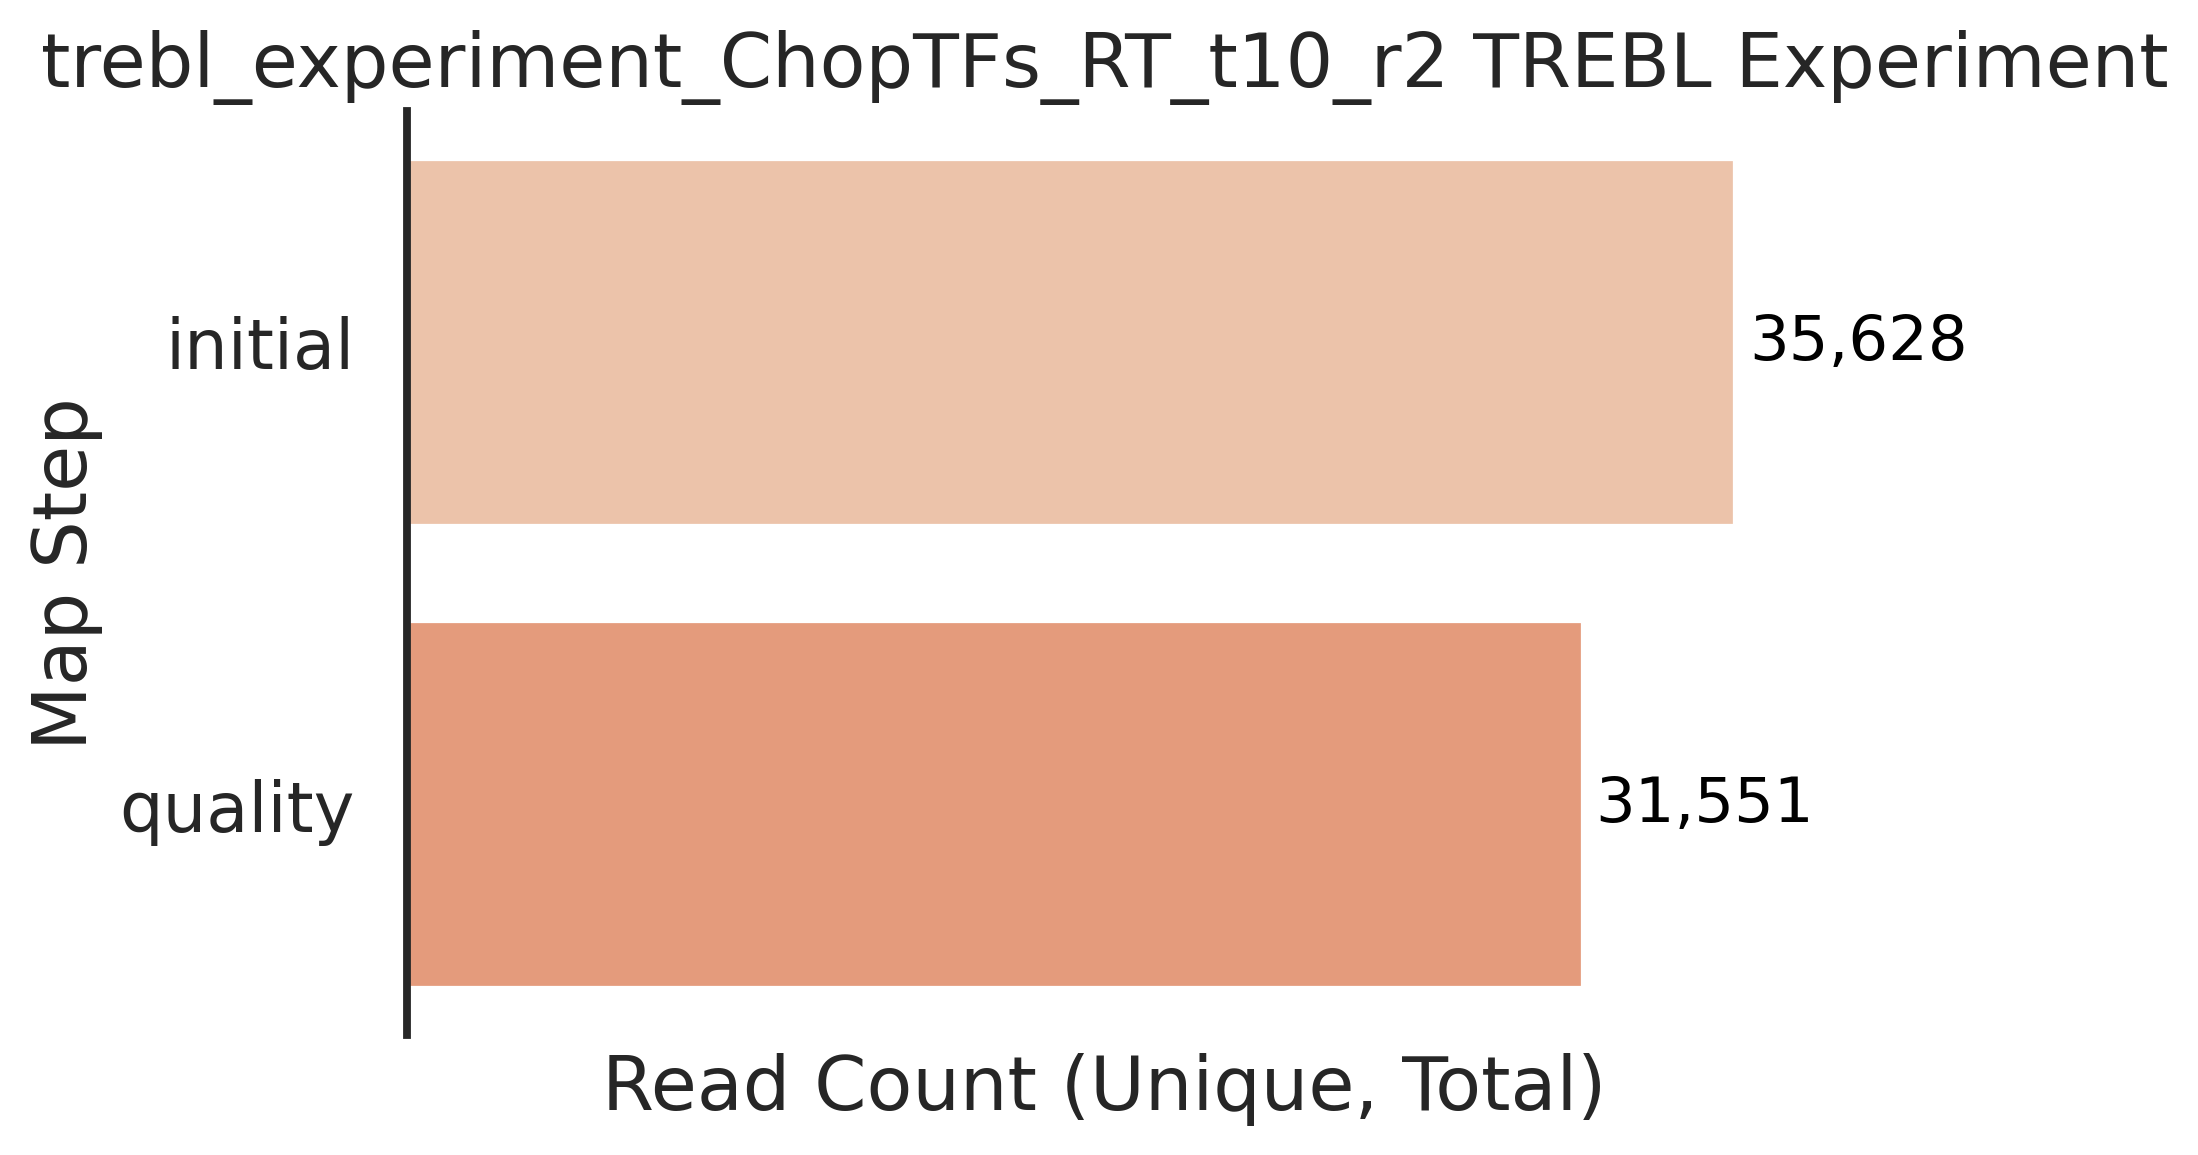

Saved to ../output/quick_start/trebl_experiment_trebl_experiment_ChopTFs_RT_t10_r2/trebl_experiment_ChopTFs_RT_t10_r2_simple_umi_counts.tsv
Saved to ../output/quick_start/trebl_experiment_trebl_experiment_ChopTFs_RT_t10_r2/trebl_experiment_ChopTFs_RT_t10_r2_reads_per_umi.tsv
Done in 0.08 seconds.

Reading 1 FASTQ/TXT file(s)...
Done in 0.52 seconds.

Reverse complement of sequences...
Done in 1.81 seconds.

Extracting 1 barcodes...
RT_BC: extracting between 'CTCGAG' and 'GGCCGC'
Done in 0.55 seconds.

Extracting UMI...
UMI: extracting 12 bases after preceder 'TGTCAC'
Done in 0.22 seconds.

Done in 0.35 seconds.

Mapping complete.
Base prefix (stable across descriptors): trebl_experiment_trebl_experiment_ChopTFs_RT_t60_r2_RT_BC_
Full prefix for this instance: trebl_experiment_trebl_experiment_ChopTFs_RT_t60_r2_RT_BC_

Using the following step order:
1. initial
2. quality


Filtering to high-quality reads...
Created table: trebl_experiment_trebl_experiment_ChopTFs_RT_t60_r2_RT_BC_quality

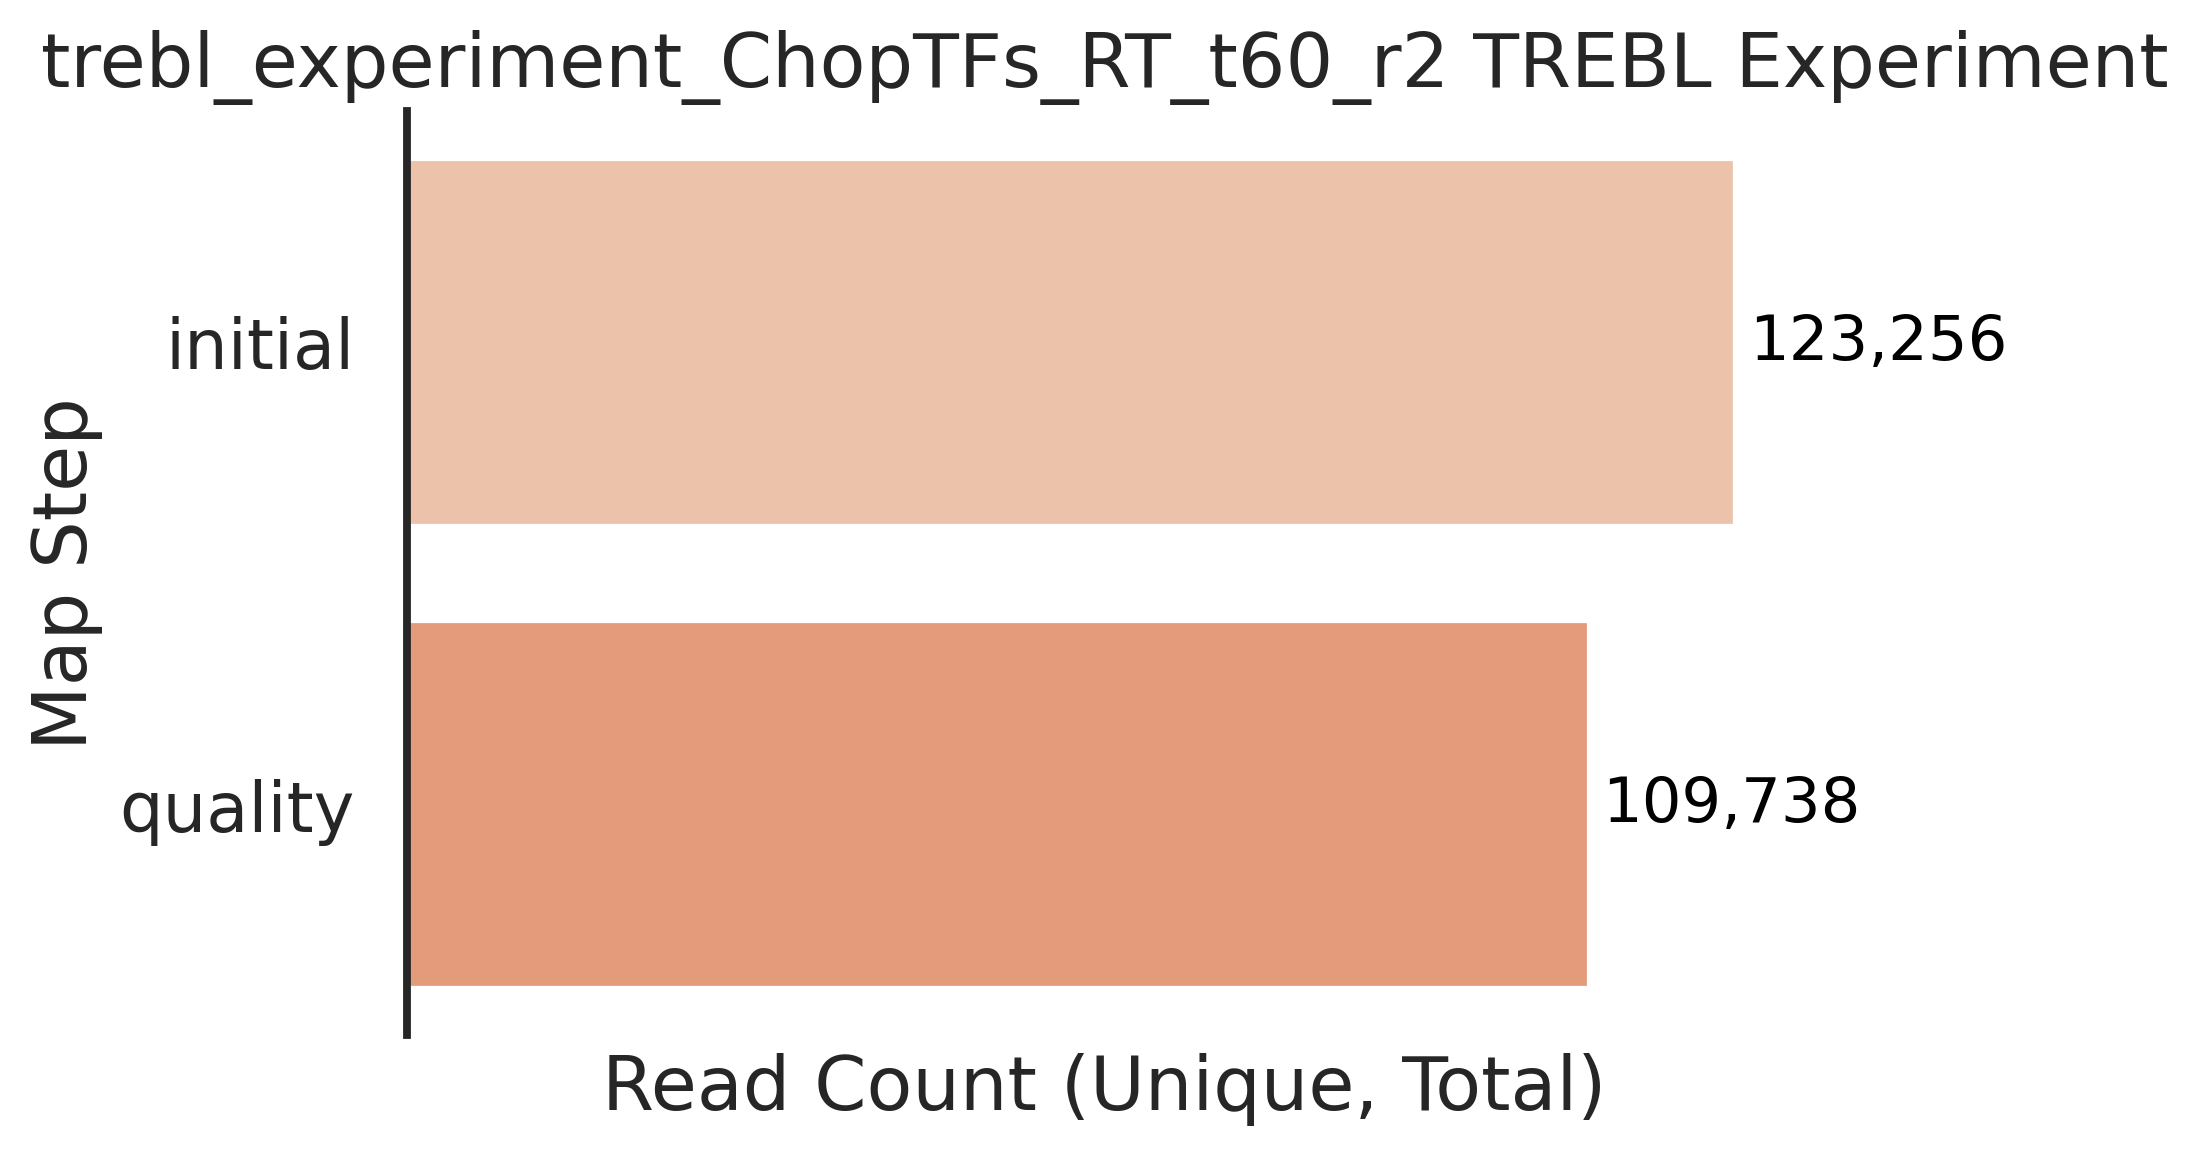

Saved to ../output/quick_start/trebl_experiment_trebl_experiment_ChopTFs_RT_t60_r2/trebl_experiment_ChopTFs_RT_t60_r2_simple_umi_counts.tsv
Saved to ../output/quick_start/trebl_experiment_trebl_experiment_ChopTFs_RT_t60_r2/trebl_experiment_ChopTFs_RT_t60_r2_reads_per_umi.tsv
Done in 0.23 seconds.



Plotting BCs: 100%|██████████| 2/2 [00:00<00:00, 21.07it/s]


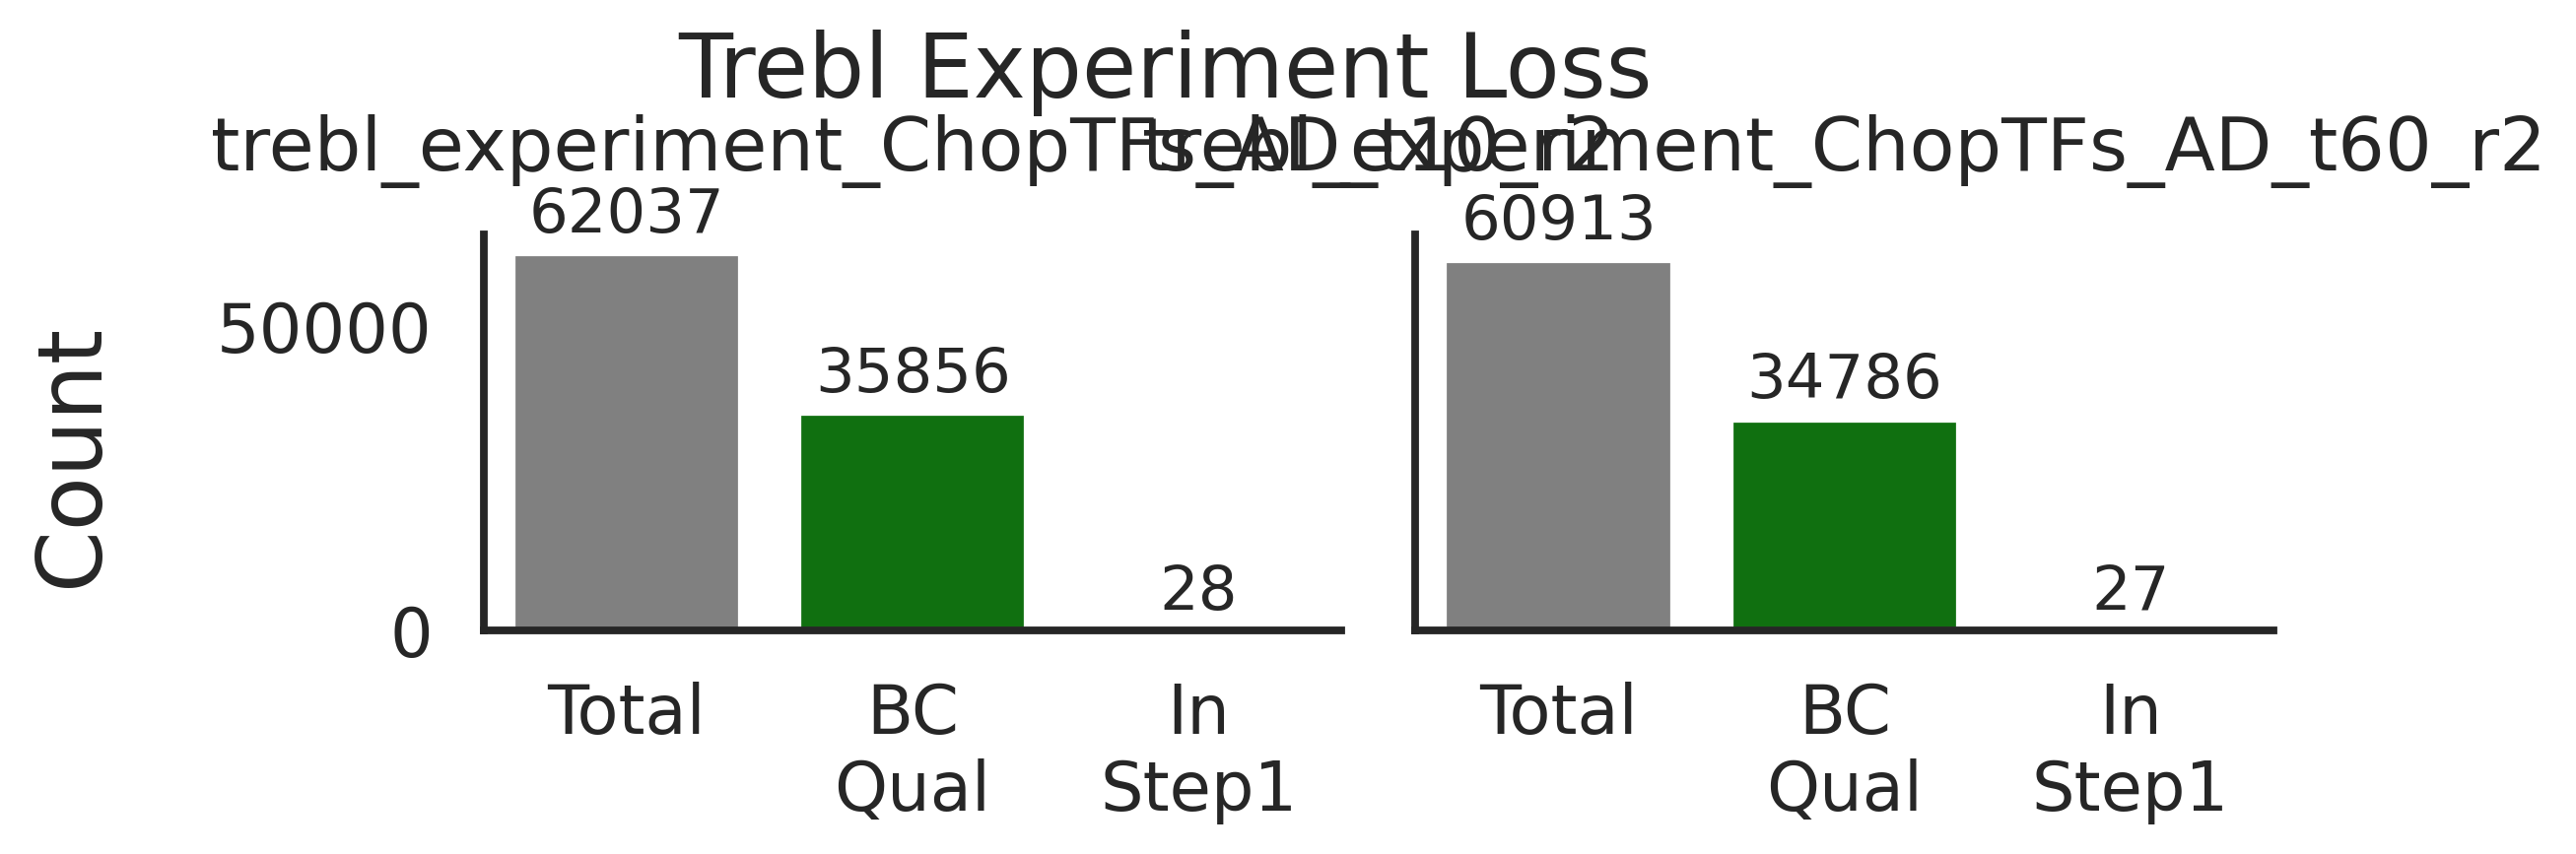

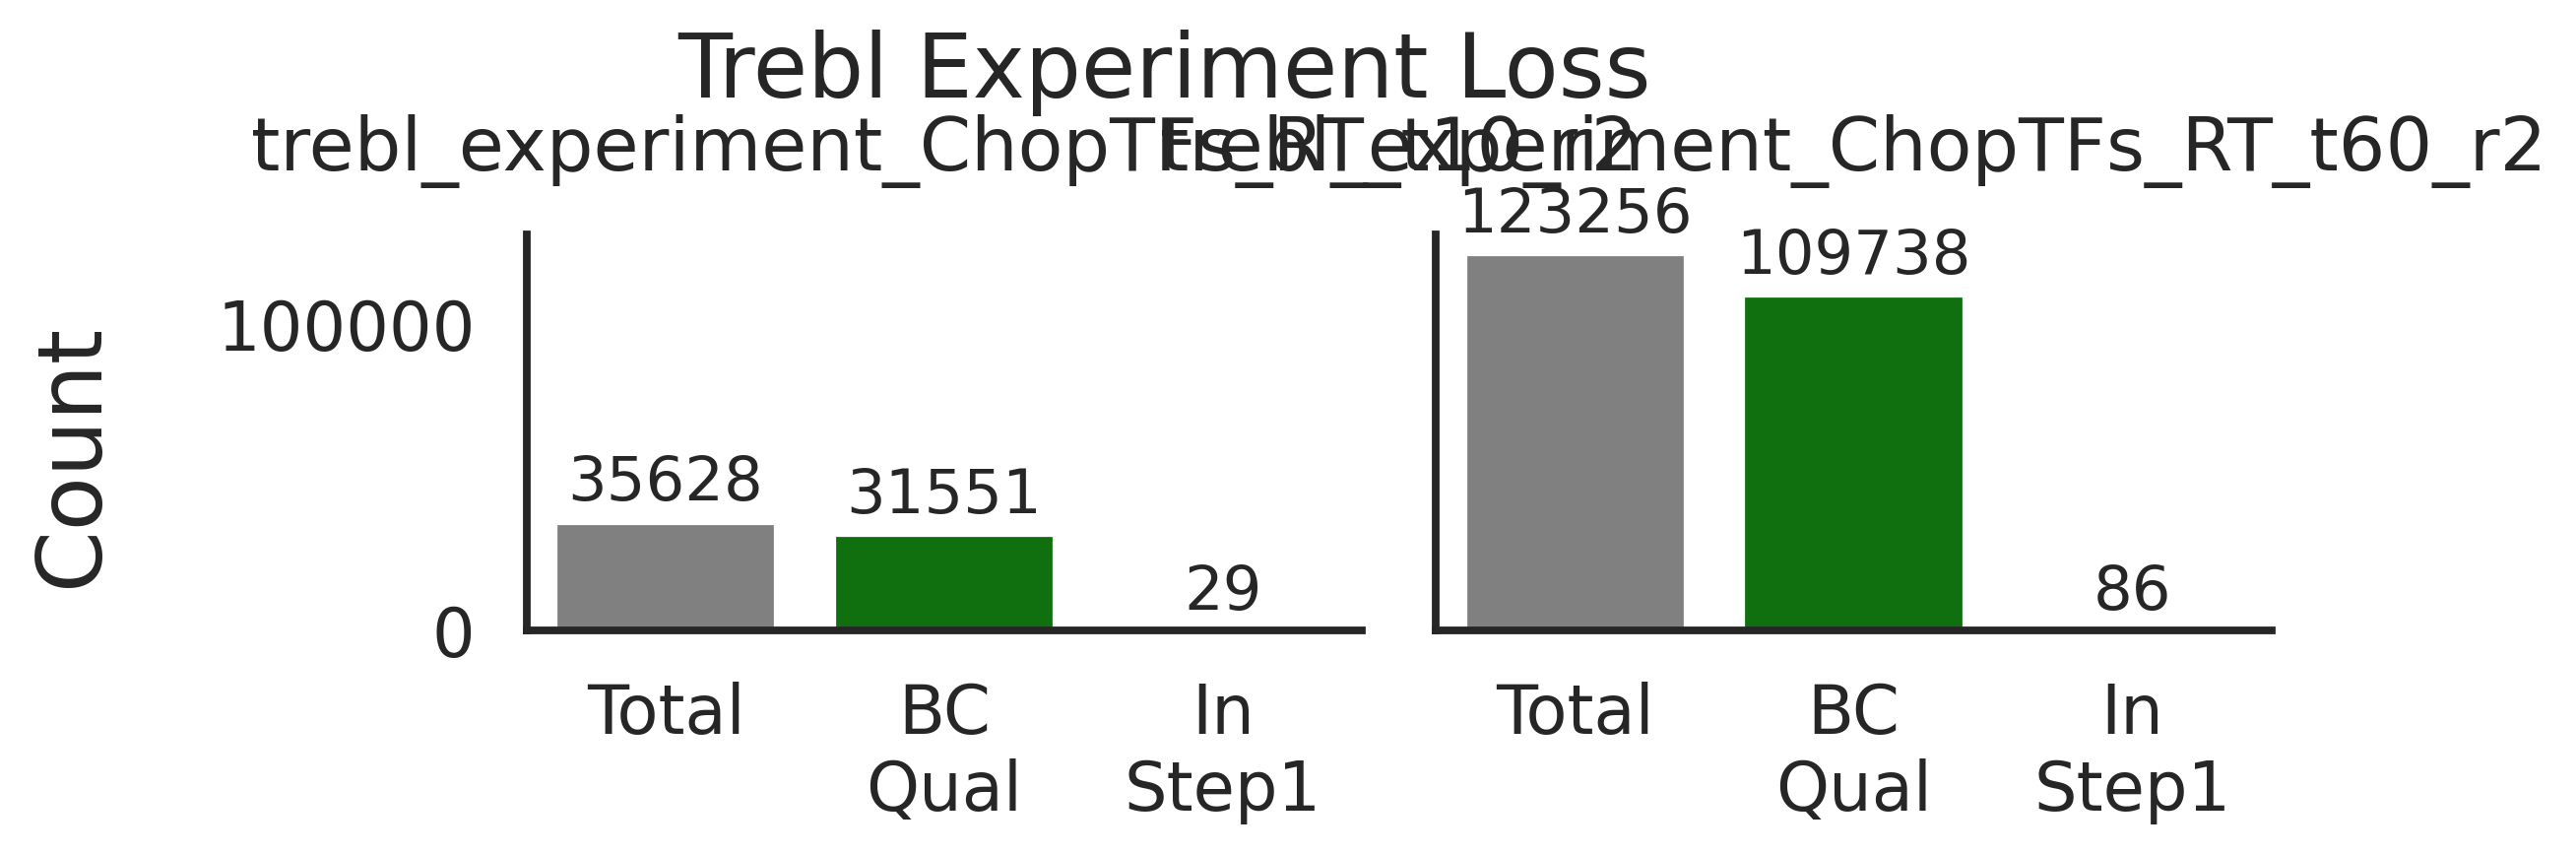

In [16]:
# Run TREBL experiment with SIMPLE UMI deduplication only
trebl_results = pipeline.trebl_experiment_analysis(
    AD_seq_files=trebl_AD_seq_files,
    AD_bc_objects=AD_bc_objects,
    RT_seq_files=trebl_RT_seq_files,
    RT_bc_objects=RT_bc_objects,
    reverse_complement=True,
    step1_map_csv_path="../output/quick_start/step1.csv",  # Update with your step1 CSV path
    AD_umi_object=AD_UMI,
    RT_umi_object=RT_UMI,
    umi_deduplication="simple",  # Use ONLY simple deduplication for quick start
)

# Access results
AD_results = trebl_results["AD_results"]
RT_results = trebl_results["RT_results"]

## Calculate Final Activity Scores

After completing the TREBL experiment analysis, calculate final activity scores from the integrated AD and RT data.

The `calculate_activity_scores` function:
- Integrates AD and RT results through the Step 1 mapping
- Extracts time and replicate metadata from sample names using regex patterns
- Calculates per-barcode and pooled gene-level activity scores

**Regex patterns**: The function uses regex to parse metadata from sample names:
- `time_regex=r"_t(\d+)"` extracts the timepoint (e.g., "24" from "sample_t24_r1")
- `rep_regex=r"_r(\d+)"` extracts the replicate number (e.g., "1" from "sample_t24_r1")

Ensure your sample names follow this convention (e.g., `ChopTFs_AD_t10_r2`).

In [17]:
pipeline.calculate_activity_scores(
    step1_path="../output/quick_start/step1.csv",
    AD_bc_objects=AD_bc_objects,
    RT_bc_objects=RT_bc_objects,
    time_regex=r"_t(\d+)",
    rep_regex=r"_r(\d+)",
)

timepoint                                                           10  \
metric                                                 bc_activity_avg   
AD                                                 rep                   
ACTGACTTTATTGATGAAGAAGTCTTGATGTCTTTGGTTATTGAAAT... 2          8.000000   
ACTTCTTCTTATGCTACTAAACAATCTAAATGTGGTAGGAAGATGTC... 2          0.000000   
ACTTGTTTGTTCTGTAAGAGATCTCATGTTGTTTGTGATAAACAAAG... 2               NaN   
ATGTATTATTCTAGACATTCTTTGTTGGGTCAATCTTCATTTATGGT... 2          0.000000   
ATTTCTTCTGGTTTGAAACCACCAGTTAATACTATTGATTTGACTAA... 2               NaN   
CCAAAATCTAAGAGAGGTGATGCTTCTGCTAATAATGATGGTTCTTC... 2          0.500000   
CCATTTCCATTGAGATTCTCATTTGCTCAAAGAGCTAAGATTGAAAT... 2          0.142857   
GATGATGCTGTTGTTGAATCTGCTGCTTCTTCTTCTACTGATTCTAC... 2               inf   
GATGTTACTCCAGCTTCTCCAATGATTAGAACTACTTCTTCTAGAGC... 2          0.500000   
GATTCTCCAGGTCCAGGATTTACTCCACATGATTCTGCTCCAGCTGG... 2               inf   
TCTACTGCTCCACCAACTGATGTTTCTTTGGGTGATGAATTGCATTT... 2               inf   
TGTGAAGATGTTCCAAATACTGCTGGTCCACATATTGCTAGACCAGT... 2               NaN   
TTCTTCTTGTTGTCTTATATTTCTGTTATGATTAATTGTACTGATGG... 2          0.000000   
TTGAAGAGAAGATCTTCTAAAGATTCTGGTGTTGGTAATAATTCTTC... 2          0.000000   
TTGACTGCTTTGACTTCTCCATCTTTGTTTGATGGTTCTCCAGACTT... 2               inf   

timepoint                                                               \
metric                                                 bc_activity_std   
AD                                                 rep                   
ACTGACTTTATTGATGAAGAAGTCTTGATGTCTTTGGTTATTGAAAT... 2               NaN   
ACTTCTTCTTATGCTACTAAACAATCTAAATGTGGTAGGAAGATGTC... 2               NaN   
ACTTGTTTGTTCTGTAAGAGATCTCATGTTGTTTGTGATAAACAAAG... 2               NaN   
ATGTATTATTCTAGACATTCTTTGTTGGGTCAATCTTCATTTATGGT... 2               NaN   
ATTTCTTCTGGTTTGAAACCACCAGTTAATACTATTGATTTGACTAA... 2               NaN   
CCAAAATCTAAGAGAGGTGATGCTTCTGCTAATAATGATGGTTCTTC... 2               NaN   
CCATTTCCATTGAGATTCTCATTTGCTCAAAGAGCTAAGATTGAAAT... 2               NaN   
GATGATGCTGTTGTTGAATCTGCTGCTTCTTCTTCTACTGATTCTAC... 2               NaN   
GATGTTACTCCAGCTTCTCCAATGATTAGAACTACTTCTTCTAGAGC... 2               NaN   
GATTCTCCAGGTCCAGGATTTACTCCACATGATTCTGCTCCAGCTGG... 2               NaN   
TCTACTGCTCCACCAACTGATGTTTCTTTGGGTGATGAATTGCATTT... 2               NaN   
TGTGAAGATGTTCCAAATACTGCTGGTCCACATATTGCTAGACCAGT... 2               NaN   
TTCTTCTTGTTGTCTTATATTTCTGTTATGATTAATTGTACTGATGG... 2               NaN   
TTGAAGAGAAGATCTTCTAAAGATTCTGGTGTTGGTAATAATTCTTC... 2               NaN   
TTGACTGCTTTGACTTCTCCATCTTTGTTTGATGGTTCTCCAGACTT... 2               NaN   

timepoint                                                               \
metric                                                 pooled_activity   
AD                                                 rep                   
ACTGACTTTATTGATGAAGAAGTCTTGATGTCTTTGGTTATTGAAAT... 2          8.000000   
ACTTCTTCTTATGCTACTAAACAATCTAAATGTGGTAGGAAGATGTC... 2          0.000000   
ACTTGTTTGTTCTGTAAGAGATCTCATGTTGTTTGTGATAAACAAAG... 2               NaN   
ATGTATTATTCTAGACATTCTTTGTTGGGTCAATCTTCATTTATGGT... 2          0.000000   
ATTTCTTCTGGTTTGAAACCACCAGTTAATACTATTGATTTGACTAA... 2               NaN   
CCAAAATCTAAGAGAGGTGATGCTTCTGCTAATAATGATGGTTCTTC... 2          0.500000   
CCATTTCCATTGAGATTCTCATTTGCTCAAAGAGCTAAGATTGAAAT... 2          0.142857   
GATGATGCTGTTGTTGAATCTGCTGCTTCTTCTTCTACTGATTCTAC... 2               inf   
GATGTTACTCCAGCTTCTCCAATGATTAGAACTACTTCTTCTAGAGC... 2          0.500000   
GATTCTCCAGGTCCAGGATTTACTCCACATGATTCTGCTCCAGCTGG... 2               inf   
TCTACTGCTCCACCAACTGATGTTTCTTTGGGTGATGAATTGCATTT... 2               inf   
TGTGAAGATGTTCCAAATACTGCTGGTCCACATATTGCTAGACCAGT... 2               NaN   
TTCTTCTTGTTGTCTTATATTTCTGTTATGATTAATTGTACTGATGG... 2          0.000000   
TTGAAGAGAAGATCTTCTAAAGATTCTGGTGTTGGTAATAATTCTTC... 2          0.000000   
TTGACTGCTTTGACTTCTCCATCTTTGTTTGATGGTTCTCCAGACTT... 2               inf   

t

## Next Steps

After completing this quick start analysis:

1. **Review outputs** in the `output/quick_start` directory
2. **Check loss tables** to understand filtering at each step
3. **Validate results** by examining the CSV files
4. **For more comprehensive analysis**, see the `full_analysis_example.ipynb` notebook which includes:
   - Error correction for improved accuracy
   - Both simple and directional/complex UMI deduplication

### Cleanup

After analysis is complete, you can delete the DuckDB database:

In [18]:
import os

os.remove("../db/quick_start.db")